# Introdução

Bem-vindo(a) ao meu projeto do desafio lighthouse 2024. Aqui meus conhecimentos sobre análise de dados e ciência de dados serão expostos no desenvolvimento de um projeto para análise dos dados de filmes avaliados pela IMDB, como também o desenvolvimento de um modelo de previsão para inferir a nota do IMDB.
O projeto foi dividido em 5 etapas diferentes. 
* Bibliotecas e Importações -> As biblitecas iniciais necessárias para a análise exploratória, junto a importação do dataset.
* Tratamento de Dados -> Aqui uma análise preliminar dos dados será realizado e as falhas encontradas serão tratadas para o modelo ficar ajustável para ser analisado graficamente.
* Análise Exploratória -> Diversos gráficos foram criados para avaliar tanto as features individualmente, como também analisar a correlação de diversos dados.
* Questionamentos Levantados -> Diversas perguntas foram propostas no desafio, sendo-as respondidas nesse tópico.
* Modelo de Previsão -> Aqui 2 modelos de previsão da nota foram criados e foi definido tanto o porquê da criação de ambos como também seu resultados.

Espero que esse trabalho demonstre toda minha expertise no campo de dados, qualquer dúvida pode entrar em contato.

# Bibliotecas e Importação dos Dados

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

## Bibliotecas de PLN
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
#nltk.download("stopwords")
#nltk.download("wordnet")



In [2]:
def import_data():
    return pd.read_csv("./Data/desafio_indicium_imdb.csv")

# Tratamento de Dados

In [3]:
dados = import_data()
dados.head(3)

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [5]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,999.0,500.000000,288.530761,1.0,250.5,500.0,749.5,999.0
IMDB_Rating,999.0,7.947948,0.272290,7.6,7.7,7.9,8.1,9.2
Meta_score,842.0,77.969121,12.383257,28.0,70.0,79.0,87.0,100.0
No_of_Votes,999.0,271621.422422,320912.621055,25088.0,55471.5,138356.0,373167.5,2303232.0


In [6]:
dados.select_dtypes(exclude=np.number).describe().T

,count,unique,top,freq
Series_Title,999,998,Drishyam,2
Released_Year,999,100,2014,32
Certificate,898,16,U,234
Runtime,999,140,130 min,23
Genre,999,202,Drama,84
Overview,999,999,An organized crime dynasty's aging patriarch t...,1
Director,999,548,Alfred Hitchcock,14
Star1,999,659,Tom Hanks,12
Star2,999,840,Emma Watson,7
Star3,999,890,Rupert Grint,5


In [7]:
dados.duplicated().sum()

0

In [8]:
# Verificar se há dados que não são numéricos.
[valor for valor in dados['Released_Year'] if not valor.isdigit()]

['PG']

In [9]:
# Verificar o título do filme faltante.
dados.loc[dados["Released_Year"] == "PG", "Series_Title"].values[0]

'Apollo 13'

**Tratamento de dados**
* Remoção da coluna Unnamed: 0
* Agrupar estrelas em uma única coluna e remover as outras
* Remover dados não numéricos da coluna released_year
* Por colunas para minúsculo.
* run time remover texto e passar para numérico.
* Preencher vázios de indicação como não informado (NI) 
  

In [78]:
def data_treatment(data):
    dt = data.copy()
    
    # Alterar nome de colunas
    dt.columns = [i.lower() for i in dt.columns]

    # Ajustar o formato de Gross
    dt["gross"] = dt["gross"].str.replace(",","").astype(float)

    # Remover texto e alterar formato.
    dt["runtime"] = dt["runtime"].str.replace("min","").astype(int)

    # Junção das tabelas.
    dt["stars"] = dt[["star1","star2","star3","star4"]].apply(lambda row: ",".join(row.values), axis=1)

    # Removendo coluna
    dt = dt.drop(["unnamed: 0","star1","star2","star3","star4"],axis=1)

    dt.loc[dt["released_year"] == "PG", "released_year"] =  "1995"

    dt["released_year"] = dt["released_year"].astype(int)

    # Preencher classificação dos filmes dizendo que não foi informado
    dt["certificate"] = dt["certificate"].fillna("NI")

    # Arrumar a faixa etária 
    faixa_etaria = {
    'U': '0+', 'A': '18+', 'UA': '12+', 'R': '18+', 'NI': 'Not Rated', 
    'PG-13': '13+', 'PG': '10+', 'Passed': '0+', 'G': '0+', 'Approved': '0+',
    'TV-PG': '10+', 'GP': '0+', 'TV-14': '14+', '16': '16+', 'TV-MA': '18+', 
    'Unrated': 'Not Rated', 'U/A': '12+'
}

    # Substituir os valores da série grupo2 usando o dicionário de mapeamento
    dt["certificate"] = dt["certificate"].replace(faixa_etaria)
    
    return dt

In [11]:
df = data_treatment(dados)
df.head(3)

,series_title,released_year,certificate,runtime,genre,imdb_rating,overview,meta_score,director,no_of_votes,gross,stars
0,The Godfather,1972,18+,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,1620367,134966411.0,"Marlon Brando,Al Pacino,James Caan,Diane Keaton"
1,The Dark Knight,2008,12+,152,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,2303232,534858444.0,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich..."
2,The Godfather: Part II,1974,18+,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,1129952,57300000.0,"Al Pacino,Robert De Niro,Robert Duvall,Diane K..."


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   series_title   999 non-null    object 
 1   released_year  999 non-null    int32  
 2   certificate    999 non-null    object 
 3   runtime        999 non-null    int32  
 4   genre          999 non-null    object 
 5   imdb_rating    999 non-null    float64
 6   overview       999 non-null    object 
 7   meta_score     842 non-null    float64
 8   director       999 non-null    object 
 9   no_of_votes    999 non-null    int64  
 10  gross          830 non-null    float64
 11  stars          999 non-null    object 
dtypes: float64(3), int32(2), int64(1), object(6)
memory usage: 86.0+ KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
released_year,999.0,1.991218e+03,2.329717e+01,1920.0,1976.0,1999.0,2009.00,2020.0
runtime,999.0,1.228719e+02,2.810123e+01,45.0,103.0,119.0,137.00,321.0
imdb_rating,999.0,7.947948e+00,2.722895e-01,7.6,7.7,7.9,8.10,9.2
meta_score,842.0,7.796912e+01,1.238326e+01,28.0,70.0,79.0,87.00,100.0
no_of_votes,999.0,2.716214e+05,3.209126e+05,25088.0,55471.5,138356.0,373167.50,2303232.0
gross,830.0,6.808257e+07,1.098076e+08,1305.0,3245338.5,23457439.5,80876340.25,936662225.0


In [14]:
df.select_dtypes(exclude=np.number).describe().T

,count,unique,top,freq
series_title,999,998,Drishyam,2
certificate,999,8,18+,343
genre,999,202,Drama,84
overview,999,999,An organized crime dynasty's aging patriarch t...,1
director,999,548,Alfred Hitchcock,14
stars,999,997,"Daniel Radcliffe,Emma Watson,Rupert Grint,Mich...",2


In [15]:
df.assign(genero = df["stars"].str.split(',')).explode("genero")["genero"].nunique()

2707

# Análise Exploratória


## Código função

**Código Para geração do Gráfico do Comportamento de cada variável**

In [16]:
df.select_dtypes(include=np.number).columns

Index(['released_year', 'runtime', 'imdb_rating', 'meta_score', 'no_of_votes',
       'gross'],
      dtype='object')

In [17]:
class EDA_variaveis:
    def __init__(self):
        self.image_conf()
        
    def image_conf(self):
        
         # Definir parâmetros do Matplotlib
        params = {
            'figure.figsize': [12,14],      # Definir o tamanho da figura (largura, altura) em polegadas
            'axes.titlesize': 10,           # Tamanho do título do gráfico
            'axes.labelsize': 10,           # Tamanho dos rótulos dos eixos
            'xtick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo x
            'ytick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo y
            'legend.fontsize': 12,          # Tamanho da fonte da legenda
            'lines.linewidth': 2,           # Largura das linhas do gráfico
            'lines.markersize': 6,          # Tamanho dos marcadores
            'axes.titlepad': 10             # Espaço entre o título e o gráfico
        }

        # Atualizar parâmetros do Matplotlib
        plt.rcParams.update(params)
    def configure_ax(self, ax, ylabel,xlabel):
        """Configura o eixo com título, rótulos e estilo."""
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        
        ax.set_xlabel(xlabel, color='grey')
        ax.set_ylabel(ylabel, color='grey')

    def annotate_bars(self, ax):
        """Adiciona anotações às barras de um gráfico de barras horizontal."""
        for p in ax.patches:
            width = p.get_width()
            ax.annotate(f'  {int(width)}', 
                        (width, p.get_y() + p.get_height() / 2), 
                        ha='left', va='center', fontsize=8, color='grey')

    def qualitativa(self, data):
        dt = data.copy()        
        tamanho = (3,2)
        
        plt.subplots_adjust(top=0.91,
                      wspace = 0.3,
                      hspace = 0.4)
    
        plt.suptitle("Gráfico de Distribuição das Variáveis Qualitativas",fontsize=20)
        # =========== Informações Sobre os Totais ==============
        pos = (0,0)
        ax = plt.subplot2grid(tamanho, pos)
            # Calculos
        total_genre = dt.assign(genero = dt["genre"].str.split(',')).explode("genero")["genero"].str.strip().nunique()
        total_stars = dt.assign(genero = dt["stars"].str.split(',')).explode("genero")["genero"].str.strip().nunique()
        total_director = dt["director"].nunique()
        total_etaria = dt["certificate"].nunique()
        
            # Entradas da tabela
        table_data = [
             [' Gêneros', total_genre],
             [' Atores',total_stars],
             [' Diretores',total_director],
             [' Etária', total_etaria]
        ]
            # Plot Tabela
        table = ax.table(cellText=table_data, colLabels=['Variáveis', 'Total de Classes'], cellLoc='center', loc='center')
        table.scale(1, 2)  # Ajustar a escala da tabela para melhor visualização
        ax.axis('off')  # Esconder os eixos

        # Ajustando a transparência das linhas da tabela
        for key, cell in table.get_celld().items():
            cell.set_alpha(0.05)  # Define a transparência das linhas da tabela
        # Ajustando estilos das células
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_text_props(weight='bold', color='grey')  # Estilo para colLabels
            else:
                cell.set_text_props(weight='normal', color='black')  # Estilo para os demais valores

        
        # =========== Gênero ==============
        pos = (0,1)
        ax = plt.subplot2grid(tamanho, pos,rowspan=2)
        plt.title("Distribuição do Gênero dos Filmes",fontsize=12)
        grupo1 = dt.assign(genero = dt["genre"].str.split(',')).explode("genero")
        grupo1["genero"] = grupo1["genero"].str.strip()    
        bar = sns.countplot(orient='h', y = grupo1["genero"], ax=ax)
        
        self.annotate_bars(ax)
        self.configure_ax(ax, "Gênero","Contagem")
         # =========== Diretores ==============
        pos = (1,0)
        ax = plt.subplot2grid(tamanho, pos)
        plt.title("Top 10 Diretores com Mais Produções",fontsize=12),
        grupo2 = dt["director"].value_counts()[:10]
        bar = sns.barplot(orient='h',x=grupo2.values, y = grupo2.index, ax=ax)
        
        self.configure_ax(ax,"Diretores","Contagem")
        self.annotate_bars(ax)
        # =========== Atores ==============
        pos = (2,0)
        ax = plt.subplot2grid(tamanho, pos)
        plt.title("Top 10 Atores com Mais Produções",fontsize=12)     
        grupo3 = dt.assign(atores = dt["stars"].str.split(',')).explode("atores")
        grupo3["atores"] = grupo3["atores"].str.strip()
        grupo3 = grupo3["atores"].value_counts()[:10]
        bar = sns.barplot(orient='h',x=grupo3.values, y = grupo3.index, ax=ax)
        
        self.configure_ax(ax,"Atores","Contagem")
        self.annotate_bars(ax)
        
        # =========== Classificação ==============
        pos = (2,1)
        ax = plt.subplot2grid(tamanho, pos)
        plt.title("Distribuição da Classificação dos Filmes",fontsize=12)
        grupo4 = df["certificate"].value_counts()
        bar = sns.barplot(orient='h', x=grupo4.values, y=grupo4.index, ax=ax)
        
        self.configure_ax(ax, "Classificação do Filme","Contagem")
        self.annotate_bars(ax)

    
    def grid_grafico(self, o, data, col):
            inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=self.outer[o], wspace=0.1, hspace=0)  # Criando 2 espaços na posição gráfica.
            ax = plt.Subplot(self.fig, inner[0])
            ax.set_title(col)
            self.fig.add_subplot(ax)
            #self.configure_ax(ax,"Diretores","Contagem")
            flierprops = dict(marker='x', markerfacecolor='r', markersize=4,linestyle='none', markeredgecolor='gold')
            box = sns.boxplot(data=df, orient='h', x = col, width=.3, color='lightyellow', flierprops=flierprops) 
            box.axis('off')
            nome = col
            # ------= Plotagem dos quantiles.
            quantiles = data[nome].quantile([0.25, 0.75]).values.tolist() # Separação dos quantiles.
            LI = quantiles[0] - ((quantiles[1] - quantiles[0])*1.5) # Limite Inferior
            LS = quantiles[1] + ((quantiles[1] - quantiles[0])*1.5) # Limite Superior
            # Ajustes de posição do LS e LI
            if LI < data[nome].min():
              LI = data[nome].min()
            elif LI >= data[nome].min():
              LI = data.loc[data[nome] >= LI, nome].min() 
            if LS > data[nome].max():
              LS = data[nome].max()
            elif LS <= data[nome].max():
              LS = data.loc[data[nome] <= LS, nome].max() 
    
            for con, ix in enumerate([LI,LS]): # Plotar no gráfico.
              if con % 2 == 0: # Se par o plot vai a direita, se não a esquerda.
                h = 'right'
              else:
                h = 'left'
              box.annotate(round(ix,2), xy=(ix, 0.18), fontsize=8, color='rosybrown', horizontalalignment=h)
            for con, ix in enumerate(quantiles):
              mover = 0.001 # Ajuste para deslocar o texto.
              if con % 2 == 0:
                h = 'right'
                ixi = ix + (ix*-mover)
              else:
                h = 'left'
                ixi = ix + (ix*mover) 
              box.annotate(round(ix,2), xy=(ixi, -0.18), fontsize=8, color='dimgrey', horizontalalignment=h, verticalalignment='bottom')

        
            ax = plt.Subplot(self.fig, inner[1])
            self.fig.add_subplot(ax)
            hist = sns.histplot(data=data, x = col,color='lightyellow') # Plotagem Histograma.
            self.configure_ax(ax, "Frequência","Dispersão")
        
    def quantitativos(self, data):
        
        dt = data.copy()
        self.outer = gridspec.GridSpec(3, 2, wspace=0.3, hspace=0.4) # Tamanho de imagem.
        rows = 3 #Linhas
        cols = 1 #Colunas
        self.fig = plt.figure(figsize=(12, 18))
        
        plt.subplots_adjust(top=0.91,
                      wspace = 0.2,
                      hspace = 0.6)
    
        plt.suptitle("Gráfico de Distribuição das Variáveis Qualitativas",fontsize=20)


        plot = df.select_dtypes(include=np.number).columns
        for n,col in enumerate(plot):
            self.grid_grafico(n, dt, col)
        



**Código para gráfico de correlação de spearman e correlação qualitativa com imdb_rating**

In [18]:
class EDA_Target:
    def __init__(self):
        self.image_conf()
        
    def image_conf(self):
        
         # Definir parâmetros do Matplotlib
        params = {
            'figure.figsize': [12,15],      # Definir o tamanho da figura (largura, altura) em polegadas
            'axes.titlesize': 10,           # Tamanho do título do gráfico
            'axes.labelsize': 10,           # Tamanho dos rótulos dos eixos
            'xtick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo x
            'ytick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo y
            'legend.fontsize': 12,          # Tamanho da fonte da legenda
            'lines.linewidth': 2,           # Largura das linhas do gráfico
            'lines.markersize': 6,          # Tamanho dos marcadores
            'axes.titlepad': 10             # Espaço entre o título e o gráfico
        }

        # Atualizar parâmetros do Matplotlib
        plt.rcParams.update(params)

    def configure_ax(self, ax, ylabel,xlabel):
        """Configura o eixo com título, rótulos e estilo."""
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        
        ax.set_xlabel(xlabel, color='grey')
        ax.set_ylabel(ylabel, color='grey')


    def plot_reg(self, dt, x, y, pos, tamanho, colspan, titulo, ylim=None):
        ax = plt.subplot2grid(
            tamanho, pos, colspan=colspan
        )
        plt.subplots_adjust(top=0.92,
                      wspace = 0.4,
                      hspace = 0.4)
        
        reg = sns.regplot(
            data = dt,
            x = x,
            y = y,
            scatter_kws={"color": "lightgrey", "alpha": 0.8},    
            line_kws={"color": "teal"},
            marker='x',
            order=2,
            ax=ax
        )
        ax.set_title(titulo, fontsize=12)
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        plt.suptitle("Comparação Entre a Nota da IMDB com Variáveis Quantitativas", fontsize=20)
        ax.set_xlabel(ax.get_xlabel(), color='grey')
        ax.set_ylabel(ax.get_ylabel(), color='grey')
    
    def quan_correlation(self, data):
        dt = data.copy()

        tamanho = (3,2)

        plots = [
            ("released_year", "imdb_rating", (0, 0), tamanho, 1, "Ano de Lançamento x Nota",[7, 10],),
            ("no_of_votes", "imdb_rating", (0, 1), tamanho, 1,  "Numéro de Votos x Nota", None, ),
            ("gross", "imdb_rating", (1, 0), tamanho,1 ,  "Bilheteria x Nota",None ),
            ("runtime", "imdb_rating", (1, 1), tamanho, 1, "Duração do Filme x Nota", None),
            ("meta_score", "imdb_rating", (2, 0), (3, 2), 2,  "Média Ponderada da Avaliação Crítica x Nota", None)
        ]
        
        for x, y, pos, tamanho, ylim, colspan, titulo in plots:
            self.plot_reg(dt, x, y, pos, tamanho, ylim, colspan, titulo)
        
        return plt.show()

    
    def correlation(self, dados):
        dt = dados.copy()
        dt = dt.drop(["series_title","overview"],axis=1)


        # Transformar coluna multilabel por row em uma coluna que repita o índice mas separa os multilabels
        dt = dt.assign(genero=dt["genre"].str.split(',')).explode("genero")
        dt = dt.assign(estrelas=dt["stars"].str.split(',')).explode("estrelas")

        # Transformar os dados categóricos em numéricos.
        transformar = dt.select_dtypes(exclude=np.number).columns
        for col in transformar:
            dt[col] = LabelEncoder().fit_transform(dt[col])

        # dropar colunas originais de gênero e estrelas.
        dt = dt.drop(["genre","stars"],axis=1)
        
        # Passa o dado como correlação
        df_matrix = dt.copy().corr()
        
        # transforma os valores no intervalo em 0
        filtro = 0.10
        df_matrix[(df_matrix < filtro) & (df_matrix > -filtro)] = 0
        
        # Passar o formato triângular para vficar melhor a visualização do heatmap
        mask = np.triu(np.ones_like(df_matrix, dtype=bool))
        
        # Plotar o gráfico
        plt.figure(figsize=(12,10))
        
        fig = sns.heatmap(df_matrix, mask=mask, annot=True, cbar=False, cmap='viridis')
        fig.set_xticklabels(fig.get_xticklabels(), rotation=45) #Faz a rotação de 45 no x
        plt.title("Gráfico de Correlação")

        # Destacar o rótulo "imdb_rating" com uma cor diferente e os outros em cinza claro
        for label in fig.get_xticklabels():
            if label.get_text() == "imdb_rating":
                label.set_color('teal')
                label.set_fontweight('bold')
            else:
                label.set_color('grey')
                
        for label in fig.get_yticklabels():
            if label.get_text() == "imdb_rating":
                label.set_color('teal')
                label.set_fontweight('bold')
            else:
                label.set_color('grey')
            
        return plt.show()
        
    def qual_correlation(self, data):
        dt = data.copy()
        plt.subplots_adjust(top=0.92,
                      wspace = 0.4,
                      hspace = 0.3)
        tamanho = (3,2)
        flierprops = dict(marker='x', markerfacecolor='r', markersize=4,linestyle='none', markeredgecolor='teal')
        plt.suptitle("Correlação Entre os Dados Qualitativos e o IMDB_Rating",fontsize=20)
        # ================ Diretor ================
        pos = (0,0)
        ax = plt.subplot2grid(tamanho, pos)
        grupo1 = dt["director"].value_counts()[:20].index
        grupo1 = dt.loc[dt["director"].isin(grupo1)]
        bar = sns.boxplot(data=grupo1,orient='h', y="director", x="imdb_rating",flierprops=flierprops)
        self.configure_ax(ax, "Diretor","IMDB_Rating")
        plt.title("Top 20 Diretores e Dispersão das Suas Notas",fontsize=12)
        # ================ ator ================
        pos = (1,0)
        ax = plt.subplot2grid(tamanho, pos)    
        grupo2 = dt.copy()
        grupo2 = dt.assign(ator = grupo2["stars"].str.split(',')).explode("ator")
        grupo2_ = grupo2["ator"].value_counts()[:20].index
        grupo2 = grupo2.loc[grupo2["ator"].isin(grupo2_)]
        bar = sns.boxplot(data=grupo2,orient='h', y="ator", x="imdb_rating",flierprops=flierprops)
        self.configure_ax(ax, "Ator","IMDB_Rating")
        plt.title("Top 20 Atores e Dispersão das Suas Notas",fontsize=12)
        
        # ================ Classifier ================
        pos = (2,0)
        ax = plt.subplot2grid(tamanho, pos) 
        grupo3 = dt.copy()
        bar = sns.boxplot(data=grupo3,orient='h', y="certificate", x="imdb_rating",flierprops=flierprops)
        plt.title("Classificação por Faixa Etária e a Dispersão das Suas Notas IMDB",fontsize=12)
        self.configure_ax(ax, "Classificação","IMDB_Rating")
        # ================ Diretor ================
        pos = (0,1)
        ax = plt.subplot2grid(tamanho, pos,rowspan=3) 
        grupo3 = dt.copy()
        grupo3 = dt.assign(genero = grupo3["genre"].str.split(',')).explode("genero")
        grupo3_ = grupo3["genero"].value_counts().index
        grupo3 = grupo3.loc[grupo3["genero"].isin(grupo3_)]
        bar = sns.boxplot(data=grupo3,orient='h', y="genero", x="imdb_rating",flierprops=flierprops)
        self.configure_ax(ax, "Gênero","IMDB_Rating")
        plt.title("Dirpersão das Notas em Função do Gênero",fontsize=12)


**Análise Gráfica Por Diretor**

In [19]:
class EDA_Director:
    def __init__(self):
        self.image_conf()
        
    def image_conf(self):
        
         # Definir parâmetros do Matplotlib
        params = {
            'figure.figsize': [12,15],      # Definir o tamanho da figura (largura, altura) em polegadas
            'axes.titlesize': 10,           # Tamanho do título do gráfico
            'axes.labelsize': 10,           # Tamanho dos rótulos dos eixos
            'xtick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo x
            'ytick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo y
            'legend.fontsize': 10,          # Tamanho da fonte da legenda
            'lines.linewidth': 2,           # Largura das linhas do gráfico
            'lines.markersize': 6,          # Tamanho dos marcadores
            'axes.titlepad': 10             # Espaço entre o título e o gráfico
        }

        # Atualizar parâmetros do Matplotlib
        plt.rcParams.update(params)
        plt.subplots_adjust(top=0.92,
                      wspace = 0.6,
                      hspace = 0.3)

    def analise_diretor(self, data):
        dt = data.copy()
        tamanho = (3,2)

        plt.suptitle("Analise Geral dos Diretores", fontsize=20)

        
        # ====== Quantidade de filmes que cada diretor participou  ======= #
        pos = (0,0)
        ax = plt.subplot2grid(tamanho, pos,colspan=2)
        grupo1 = dt["director"].value_counts().value_counts()
        barras = sns.barplot(orient='h', x = grupo1.values, y = grupo1.index, ax=ax)
        total = grupo1.sum()
        for index, value in enumerate(grupo1.values):
            percentage = (value / total) * 100
            ax.annotate(f'  {value} ({percentage:.1f}%)', xy=(value, index), va='center',fontsize=8, horizontalalignment='left')
            
        plt.xlim([0,450])
        plt.title("Quantidade da Participação de Cada Diretor na Produção" ,fontsize=12)
        
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Número de Diretores que Dirigiram", color='grey')
        ax.set_ylabel("Quantidade de Filmes Dirigidos", color='grey')
        
        # ====== O lucro médio que cada filme de cada diretor participou ======= #
        pos = (1,0)
        ax = plt.subplot2grid(tamanho, pos,colspan=2)
        grupo2 = dt.copy()
        filtro_quantidade_filmes = 3
        lista_4 = grupo2["director"].value_counts()[grupo2["director"].value_counts()>=filtro_quantidade_filmes].index
        grupo2 = grupo2.loc[grupo2["director"].isin(lista_4)]
        grupo2 = grupo2.groupby(["director"])["gross"].median().sort_values(ascending=False)[:10]
        barras = sns.barplot(orient="h",x = grupo2.values,y = grupo2.index,ax=ax)
        
        plt.xlim([0,grupo2.values.max()*1.2])
        plt.title("Rank Top 10 Lucro Médio por Diretor" ,fontsize=12)
        
        for index, value in enumerate(grupo2.values):
            ax.annotate(f'  U$ {value/1000000:.1f} M', xy=(value, index), va='center',fontsize=8, horizontalalignment='left')

        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Lucro Médio", color='grey')
        ax.set_ylabel("Diretor", color='grey')
        
        # ====== Média a nota Geral ======= #
        flierprops = dict(marker='x', markerfacecolor='r', markersize=4, linestyle='none', markeredgecolor='darkcyan') 
        lista_diretores = grupo2.index
        pos = (2,0)
        ax = plt.subplot2grid(tamanho, pos)
        grupo3 = dt.copy()
        grupo3 = grupo3.loc[grupo3["director"].isin(lista_diretores)]
        caixa = sns.boxplot(orient='h',x = grupo3["meta_score"], width=0.5,y = grupo3["director"].astype(str),ax=ax, flierprops=flierprops)
        plt.title("Dispersão das Notas Ponderadas por Diretor" ,fontsize=12)
        
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel(ax.get_xlabel(), color='grey')
        ax.set_ylabel("Diretor", color='grey')
        
        # ====== Média a nota Geral ======= #
        lista_diretores = grupo2.index
        pos = (2,1)
        ax = plt.subplot2grid(tamanho, pos)
        grupo4 = dt.copy()
        grupo4 = grupo4.loc[grupo4["director"].isin(lista_diretores)]
        caixa = sns.boxplot(orient='h',x = grupo4["imdb_rating"],y = grupo4["director"].astype(str),ax=ax,width=0.5,flierprops=flierprops)
        plt.title("Dispersão das Notas IMDB por Diretor" ,fontsize=12)
            
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel(ax.get_xlabel(), color='grey')
        ax.set_ylabel("Diretor", color='grey')

    def analise_diretor_individual(self, data, diretor):
        dt = data.copy()
        
        tamanho = (4,2)
        plt.subplots_adjust(top=0.92,
                      wspace = 0.6,
                      hspace = 0.5)
        dt = dt.loc[dt["director"] == diretor]

        # =========== Informações sobre o diretor ==============
        pos = (0,0)
        ax = plt.subplot2grid(tamanho, pos)
            # Calculos
        mean_imdb_rating = dt["imdb_rating"].mean()
        mean_gross = dt["gross"].mean()
        mean_voter = dt["no_of_votes"].mean()
        mean_score = dt["meta_score"].mean()
        total_movies = dt["series_title"].count()
        total_gross = dt["gross"].sum()
        
            # Entradas da tabela
        table_data = [
             ['Total de filmes dirigidos', total_movies],
            ['Média de votos por filme', f'{mean_voter}'],
            ['Média nota IMDb', f'{mean_imdb_rating:.2f}'],
            ['Média nota META', f'{mean_score:.2f}'],
            ['Média de lucro', f'$ {mean_gross:.2f}M'],
            ['Lucro total acumulado', f'$ {total_gross:.2f} M']
           
        ]
            # Plot Tabela
        table = ax.table(cellText=table_data, colLabels=['Descrição', 'Valor'], cellLoc='center', loc='center')
        table.scale(1, 2)  # Ajustar a escala da tabela para melhor visualização
        ax.axis('off')  # Esconder os eixos

        
        # Ajustando a transparência das linhas da tabela
        for key, cell in table.get_celld().items():
            cell.set_alpha(0.05)  # Define a transparência das linhas da tabela
        # Ajustando estilos das células
        for (i, j), cell in table.get_celld().items():
            if i == 0:
                cell.set_text_props(weight='bold', color='black')  # Estilo para colLabels
            else:
                cell.set_text_props(weight='normal', color='black')  # Estilo para os demais valores

        
        #  ========= Filmes ================
        
        pos = (0,1)
        ax = plt.subplot2grid(tamanho, pos)
        dt["series_title"]  = dt["series_title"].str.replace(":","\n")
        barra = sns.barplot(data = dt,orient='h',y = "series_title",x = "imdb_rating")
        n = 0
        for i in dt.imdb_rating:
            plt.annotate(f"  {i}", xy=(i,n))
            n+= 1
            
        plt.xlim([0,dt.imdb_rating.max()*1.1])
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')

        plt.title("Filmes Dirigidos", fontsize=12)
                # Definir cor dos rótulos dos eixos
        ax.set_xlabel(ax.get_xlabel(), color='grey')
        ax.set_ylabel("Filmes", color='grey')
        
        # ========= ano de atuação ================
        pos = (1,0)
        ax = plt.subplot2grid(tamanho, pos, colspan=2)
        grupo1 = dt.groupby("released_year")["gross"].agg(["sum","count"])
        linhas = sns.lineplot(x = grupo1["sum"].index,y = grupo1["sum"].values,marker="o")

        
        
        valores_milhoes = [valor / 1000000 for valor in grupo1["sum"].values]
        filmes_por_ano = grupo1["count"].values.tolist()
        anos = grupo1["count"].index
        for valor, filmes, ano in zip(valores_milhoes, filmes_por_ano, anos):
            plt.annotate(f'  {valor:.0f}M U$\n{filmes} filmes \nem {ano}', xy=(ano, (valor*1000000)*1.07), va='bottom', ha='center', fontsize=8)

        plt.ylim([0,grupo1.values.max()*1.3])
        
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')

        plt.title("Receita por Ano de Atuação", fontsize=12)
        # Definir cor dos rótulos dos eixos
        ax.set_xlabel("Ano de Lançamento", color='grey')
        ax.set_ylabel("Lucro", color='grey')
        
        # ========= Generos ================ 
        pos = (2,0)
        ax = plt.subplot2grid(tamanho, pos)
        grupo2 = dt.copy()
        grupo2 = grupo2.assign(genero = grupo2["genre"].str.split(',')).explode("genero")
        grupo2["genero"] = grupo2["genero"].str.strip()
        grupo2 = grupo2["genero"].value_counts()

        barras = sns.barplot(y = grupo2.index,x = grupo2.values)

        n = 0
        for i in grupo2.values:
            plt.annotate(f"  {i}", xy=(i,n))
            n+= 1
        plt.xlim([0, grupo2.values.max()*1.1])

        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        
        plt.title("Gêneros Dirigidos", fontsize=12)
        # Definir cor dos rótulos dos eixos
        ax.set_xlabel("Quantidade", color='grey')
        ax.set_ylabel(ax.get_ylabel(), color='grey')
        # ========= Atores ================  
        pos = (2,1)
        ax = plt.subplot2grid(tamanho, pos)
        grupo3 = dt.copy()
        grupo3 = grupo3.assign(atores = grupo3["stars"].str.split(',')).explode("atores")
        grupo3["atores"] = grupo3["atores"].str.strip()
        grupo3 = grupo3["atores"].value_counts()
        barras = sns.barplot(y = grupo3.index,x = grupo3.values)

        n = 0
        for i in grupo3.values:
            plt.annotate(f"  {i}", xy=(i,n))
            n+= 1
            
        plt.xlim([0, grupo3.values.max()*1.1])
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')

        plt.title("Colaboração Entre Diretor e Ator", fontsize=12)
        ax.set_xlabel("Quantidade", color='grey')
        ax.set_ylabel(ax.get_ylabel(), color='grey')

        plt.suptitle("Análise Individual por Diretor", fontsize=20)

        

**Análise por Ator**

In [20]:
class EDA_Actor:
    def __init__(self):
        self.image_conf()
        
    def image_conf(self):
        
         # Definir parâmetros do Matplotlib
        params = {
            'figure.figsize': [12,18],      # Definir o tamanho da figura (largura, altura) em polegadas
            'axes.titlesize': 10,           # Tamanho do título do gráfico
            'axes.labelsize': 10,           # Tamanho dos rótulos dos eixos
            'xtick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo x
            'ytick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo y
            'legend.fontsize': 10,          # Tamanho da fonte da legenda
            'lines.linewidth': 2,           # Largura das linhas do gráfico
            'lines.markersize': 6,          # Tamanho dos marcadores
            #'axes.titlepad': 20             # Espaço entre o título e o gráfico
        }

        # Atualizar parâmetros do Matplotlib
        plt.rcParams.update(params)
    def analise_ator(self,data):
        
        dt = data.copy()
        tamanho = (3,2)
        plt.subplots_adjust(top=0.92,
                      wspace = 0.6,
                      hspace = 0.4)
        plt.suptitle("Analise Geral dos Atores", fontsize=20)

        
        # ====== Quantidade de filmes que cada diretor participou  ======= #
        pos = (0,0)
        ax = plt.subplot2grid(tamanho, pos,colspan=2)
        dt = dt.assign(atores = dt["stars"].str.split(',')).explode("atores")
        dt["atores"] = dt["atores"].str.strip()
        grupo1 = dt["atores"].value_counts().value_counts()
        barras = sns.barplot(orient='h', x = grupo1.values, y = grupo1.index, ax=ax)
        total = grupo1.sum()
        for index, value in enumerate(grupo1.values):
            percentage = (value / total) * 100
            ax.annotate(f'  {value} ({percentage:.1f}%)', xy=(value, index), va='center',fontsize=8, horizontalalignment='left')
        
        plt.title("Quantidade da Participação de Cada Ator por Filme" ,fontsize=12)
        
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Número de Atores que Atuaram", color='grey')
        ax.set_ylabel("Quantidade de Filmes Atuados", color='grey')
        
        # ====== O lucro médio que cada filme de cada diretor participou ======= #
        pos = (1,0)
        ax = plt.subplot2grid(tamanho, pos,colspan=2)
        grupo2 = dt.copy()
        filtro_quantidade_filmes = 3
        lista_4 = grupo2["atores"].value_counts()[grupo2["atores"].value_counts()>=filtro_quantidade_filmes].index
        grupo2 = grupo2.loc[grupo2["atores"].isin(lista_4)]
        grupo2 = grupo2.groupby(["atores"])["gross"].median().sort_values(ascending=False)[:10]
        barras = sns.barplot(orient="h",x = grupo2.values,y = grupo2.index,ax=ax)
        
        plt.xlim([0,grupo2.values.max()*1.2])
        plt.title("Rank Top 10 Lucro Médio por Ator" ,fontsize=12)
        
        for index, value in enumerate(grupo2.values):
            ax.annotate(f'  U$ {value/1000000:.1f} M', xy=(value, index), va='center',fontsize=8, horizontalalignment='left')

        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Lucro Médio", color='grey')
        ax.set_ylabel("Ator", color='grey')
        
        # ====== Média a nota Geral ======= #
        flierprops = dict(marker='x', markerfacecolor='r', markersize=4, linestyle='none', markeredgecolor='darkcyan') 
        lista_atores = grupo2.index
        pos = (2,0)
        ax = plt.subplot2grid(tamanho, pos)
        grupo3 = dt.copy()
        grupo3 = grupo3.loc[grupo3["atores"].isin(lista_atores)]
        caixa = sns.boxplot(orient='h',x = grupo3["meta_score"], width=0.5,y = grupo3["atores"].astype(str),ax=ax, flierprops=flierprops)
        plt.title("Dispersão das Notas Ponderadas por Ator" ,fontsize=12)
        
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel(ax.get_xlabel(), color='grey')
        ax.set_ylabel("Diretor", color='grey')
        
        # ====== Média a nota Geral ======= #
        pos = (2,1)
        ax = plt.subplot2grid(tamanho, pos)
        grupo4 = dt.copy()
        grupo4 = grupo4.loc[grupo4["atores"].isin(lista_atores)]
        caixa = sns.boxplot(orient='h',x = grupo4["imdb_rating"],y = grupo4["atores"].astype(str),ax=ax,width=0.5,flierprops=flierprops)
        plt.title("Dispersão das Notas IMDB por Ator" ,fontsize=12)
            
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel(ax.get_xlabel(), color='grey')
        ax.set_ylabel("Diretor", color='grey')

        
    

**Análise por Lucro**

In [21]:
class EDA_Lucro:
    def __init__(self):
        self.image_conf()
        
    def image_conf(self):
        
         # Definir parâmetros do Matplotlib
        params = {
            'figure.figsize': [12,18],      # Definir o tamanho da figura (largura, altura) em polegadas
            'axes.titlesize': 10,           # Tamanho do título do gráfico
            'axes.labelsize': 10,           # Tamanho dos rótulos dos eixos
            'xtick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo x
            'ytick.labelsize': 8,          # Tamanho dos rótulos dos ticks do eixo y
            'legend.fontsize': 10,          # Tamanho da fonte da legenda
            'lines.linewidth': 2,           # Largura das linhas do gráfico
            'lines.markersize': 6,          # Tamanho dos marcadores
            #'axes.titlepad': 20             # Espaço entre o título e o gráfico
        }

        # Atualizar parâmetros do Matplotlib
        plt.rcParams.update(params)
        
    def analise_lucro(self, data):
        dt = data.copy()
        tamanho = (3,2)
        plt.subplots_adjust(top=0.92,
                      wspace = 0.6,
                      hspace = 0.4)

        plt.suptitle("Análise do Lucro", fontsize=20)
        # ================ Genero x Lucro ************
        pos = (0,0)
        ax = plt.subplot2grid(tamanho,pos)
        flierprops = dict(marker='x', markerfacecolor='r', markersize=4, linestyle='none', markeredgecolor='darkcyan') 
        
        grupo1 = dt.assign(genero = dt["genre"].str.split(',')).explode("genero")
        grupo1["genero"] = grupo1["genero"].str.strip()
        y = grupo1["genero"].tolist()
        x = grupo1["gross"].tolist()
        caixa = sns.boxplot(orient='h',y = y,x = x,flierprops=flierprops)
            # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Lucro", color='grey')
        ax.set_ylabel("Genero", color='grey')
        plt.title("Dispersão do Lucro por Gênero",fontsize=12)
        
        # =============== Votos x Lucro  ************
        pos = (0,1)
        ax = plt.subplot2grid(tamanho, pos)
        sct = sns.regplot(data=dt,x = "gross",y = "no_of_votes",scatter_kws={"color": "grey", "alpha": 0.5},line_kws={"color": "teal"},marker='x',order=1)
            # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Lucro", color='grey')
        ax.set_ylabel(ax.get_ylabel(), color='grey')
        plt.title("Dispersão do Lucro x Votos",fontsize=12)
        
        # ================ Lucro x runtime  ************
        pos = (1,0)
        ax = plt.subplot2grid(tamanho, pos)
        sct = sns.regplot(data=dt,x = "gross",y = "released_year",scatter_kws={"color": "grey", "alpha": 0.5},line_kws={"color": "teal"},marker='x',order=1)
            # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Lucro", color='grey')
        ax.set_ylabel(ax.get_ylabel(), color='grey')
        plt.title("Dispersão do Lucro x Ano de Lançamento",fontsize=12)
    
        # ============== Lucro x IMDB rating  ************
        pos = (1,1)
        ax = plt.subplot2grid(tamanho, pos)
        box = sns.boxplot(orient = 'h', x = dt["gross"], y = dt["imdb_rating"].astype(str),flierprops=flierprops)
            # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Lucro", color='grey')
        ax.set_ylabel(ax.get_ylabel(), color='grey')
        plt.title("Dispersão do Lucro x Votos",fontsize=12)
        
        # =============== Classificação x Lucro ************
        
        pos = (2,0) 
        ax = plt.subplot2grid(tamanho, pos, colspan=2)
        box = sns.boxplot(orient="h", x = dt["gross"], y = dt["certificate"],flierprops=flierprops)
        # Remover linhas superior e direita e definir a cor das outras linhas como cinza
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgrey')
        ax.spines['bottom'].set_color('lightgrey')
        ax.set_xlabel("Lucro", color='grey')
        ax.set_ylabel("Classificação", color='grey')
        plt.title("Faixa Etária pelo Lucro",fontsize=12)

        
        return plt.show()


## Análise Gráfica 

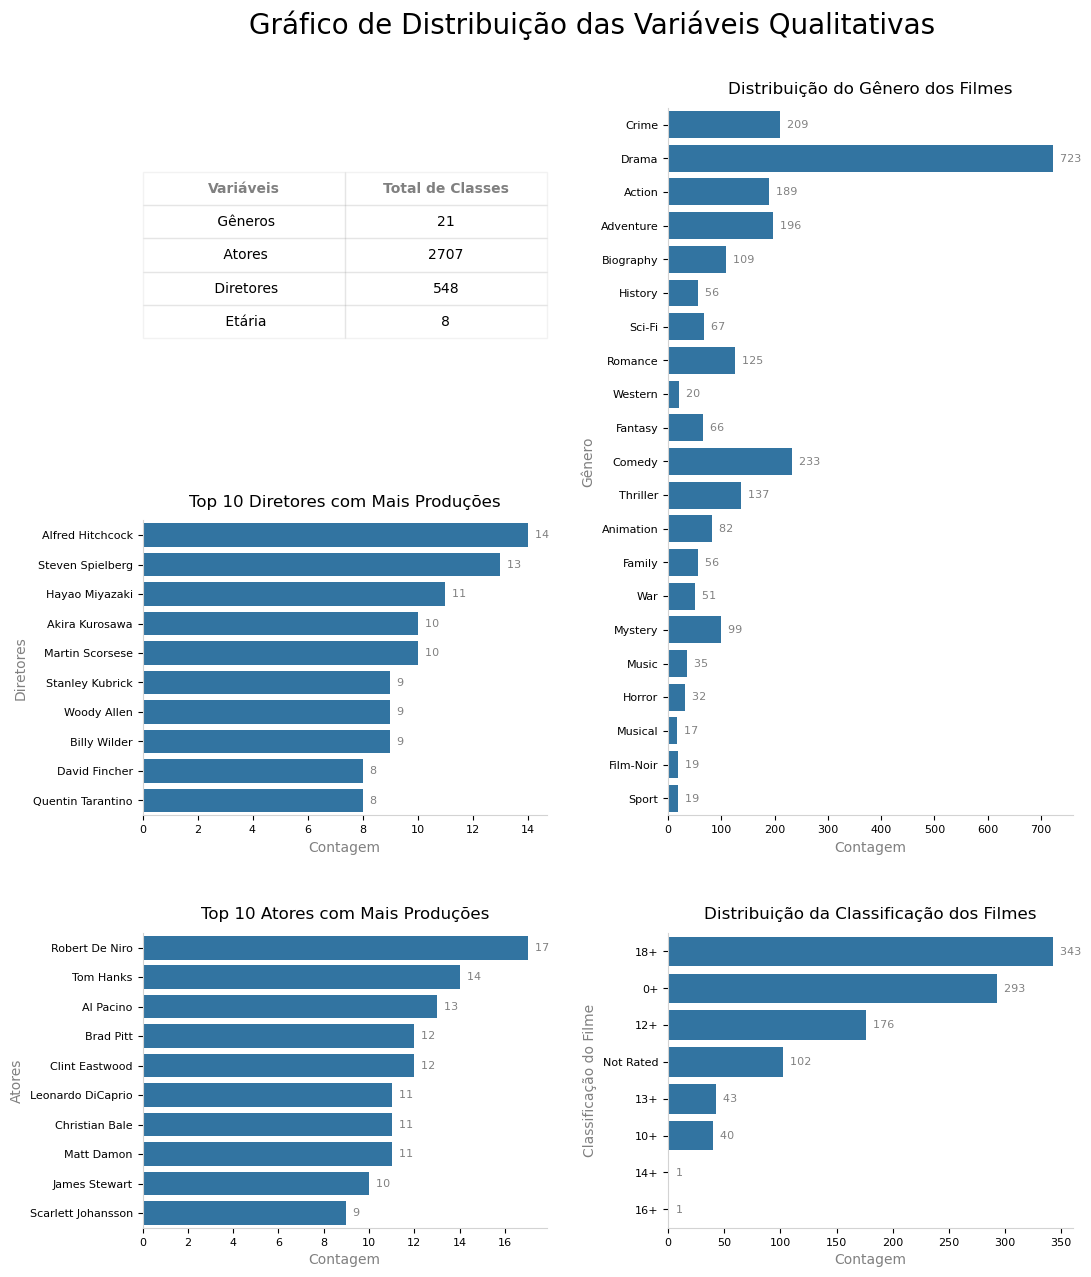

In [22]:
grafico = EDA_variaveis()
grafico.qualitativa(df)

**Análise Gráfica**
* Olhando a tabela do gráfico acima comparado as informações dos dados no tratamento, podemos ver uma diferença entre a quantidade de atores e de gêneros, isso se dá porque cada linha apresenta mais de um gênero e ator, sendo então necessário fazer a sua separação para a análise, com isso vemos que o número de gêneros é bem menor, sendo 21 classes e de atores sendo bem maior, chegando a aproximadamente 2700. Ainda sobre os gêneros, vemos que a maioria é de Drama, mas também tendo destaque para comédia, ação, aventura e crime.
* Como atores e diretores apresentam uma grande quantidade de dados, ambos serão estudados separadamente mais a frente, mas podemos destacar Robert De Niro como o ator com mais participações e Alfred Hitchcock como o Diretor com mais produções.
* Analisando agora a faixa etária dos dados, observa-se uma grande quantidade de filmes para adultos.

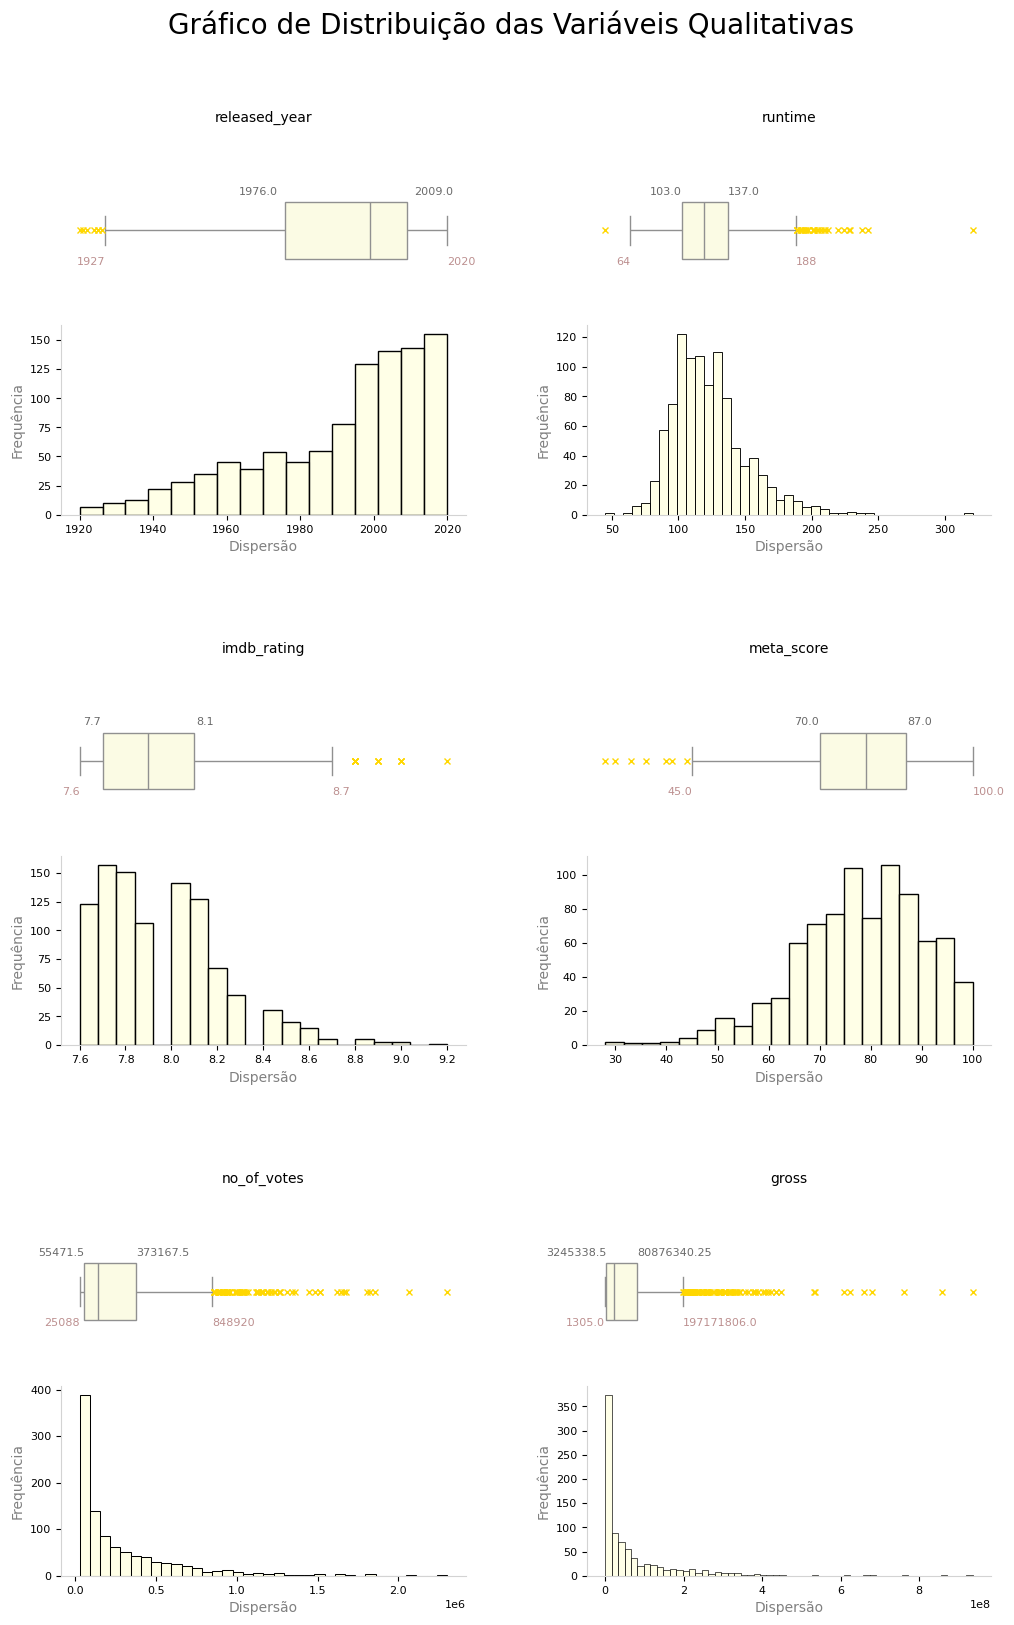

In [23]:
grafico.quantitativos(df)

**Análise Gráfica**
* Para analisar os dados quantitativos foi utilizado dois tipos de gráficos, o de caixa e o histograma. O gráfico de caixa (boxplot) oferece uma visão clara da distribuição dos dados, destacando a mediana, quartis e possíveis outliers, permitindo uma comparação rápida entre diferentes conjuntos de dados. Já o histograma mostra a frequência das observações dentro de intervalos especificados, revelando a forma da distribuição dos dados, como a presença de assimetrias ou múltiplos picos. Juntos, esses gráficos proporcionam uma compreensão detalhada e visualmente intuitiva das características principais de variáveis quantitativas.
* Analisando o ano de lançamento dos filmes, vemos que 75% dos dados são a partir de 1976, sendo a frequência mais alta a partir dos anos 2000, apresentando também uma distribuição exponencial.
* Em relação ao tempo de duração do filme, vemos que ele se apróxima de ums distribuição normal, mas apresenta uma assimetria positiva, com a frequência maior em torno de 1 hora e 40 min de filme como maior frequência. Vale destacar que filmes com mais de 3 horas são considerados outliers.
* Ao avaliar a nota do IMDB, vemos que notas acima de 8.7 são consideradas outliers, ou seja, uma nota muito difícil de ser alcançada e ao vermos que 75% dos dados estão abaixo de 8.1, podemos assumir que qualquer valor acima disso já obteve um excelente desempenho na avaliação. Sobre o tipo de distribuição, podemos dizer que se aproxima da gamma, mas seria uma normal com uma elevada assimetria.
* Já na avaliação do meta, filmes com desempenho ruim, abaixo de 45 pontos é que são a raridade, ou seja, vemos um critério muito elevado para o IMDB e um menor para o meta, visto que sua distribuição alcança até os 100 pontos. A distribuição aqui apresenta uma assimetria negativa.
* Em relação ao número de votos, vemos uma distribuição exponencial e totalmente concentrada em valores menores, com 75% dos dados abaixo de 373 mil votos e valores acima de 848920 sendo considerados outliers, provavelmente aqueles filmes de alta popularidade e do momento.
* Em relação ao lucro vemos um cenário muito parecido, onde 75% dos filmes chegam a ter um lucro de até 80.876.340 dolares e filme que superam os 197.171.806 dolares sendo outliers

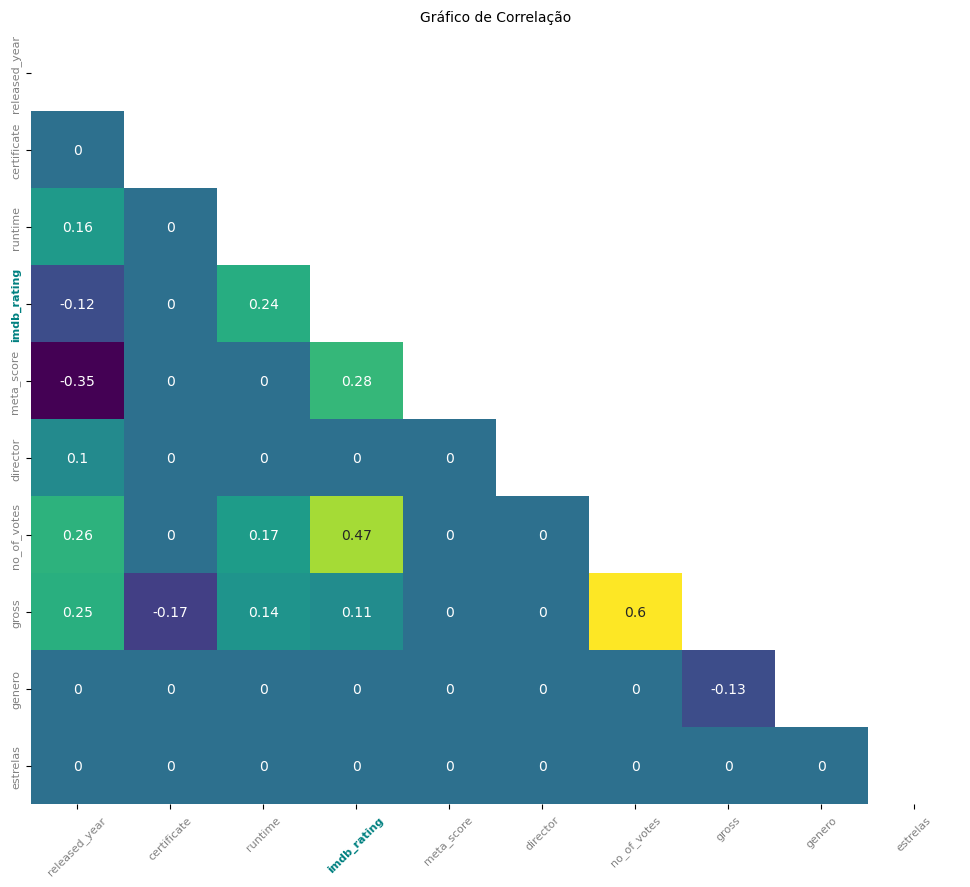

In [24]:
graficos = EDA_Target()
graficos.correlation(df)

**Analisando o gráfico de correlação acima**

* *Sobre o modelo utilizado*
  * O gráfico de correlação acima é um heatmap que representa visualmente a matriz de correlação entre as variáveis de um conjunto de dados. A matriz de correlação é uma ferramenta estatística que mede o grau de associação linear entre pares de variáveis. Cada célula na matriz mostra o coeficiente de correlação entre duas variáveis, que varia de -1 a 1. O método estatístico usado para calcular as correlações no gráfico é o coeficiente de correlação de Pearson. Este coeficiente quantifica a força e a direção da relação linear entre duas variáveis contínuas.
* *Conclusão e hipóteses com a variável resposta*
  * Começando pela variável de interesse *imdb_rating*, ela apresenta uma forte correlação com o número de votos. A hipótese aqui recai sobre uma possível popularidade do filme, sugerindo que quanto mais popular o filme, um número maior de pessoas pode buscar votar, qualificando aquele filme.
  * Outra correlação do *imdb_rating* que apresentou um certo destaque foi com o atributo *meta_score*, sendo esse a média ponderada de todos os críticos do filme. Uma percepção pessoal é que, geralmente, a nota do público tende a diferenciar bastante dos críticos, então uma correlação pode ser encontrada entre ambos, mas fica claro que não é algo diretamente interligado.
  * Algo curioso é sobre a duração do tempo do filme, que agora deve ser explorado para saber se é somente uma coincidência ou há algum tipo de correlação aí.
  * Com correlação menor que `0.2`, vemos que o ano de lançamento e o lucro gerado são fatores relevantes, também vale um estudo sobre.
* *Conclusão e hipóteses com as variáveis explicativas* 
  * Sobre o lucro obtido, o número de votos também segue a lógica de ser um filme popular e acabar gerando mais engajamento. Sobre a classificação, talvez filmes com uma classificação aberta gerem uma receita maior, algo que deve ser explorado. O ano provavelmente influencia por conta da inflação, ou seja, o preço do ingresso acaba aumentando com o tempo.
  * As correlações menores que `0.2` vão ser exploradas mais a frente para uma compreensão mais elaborada.

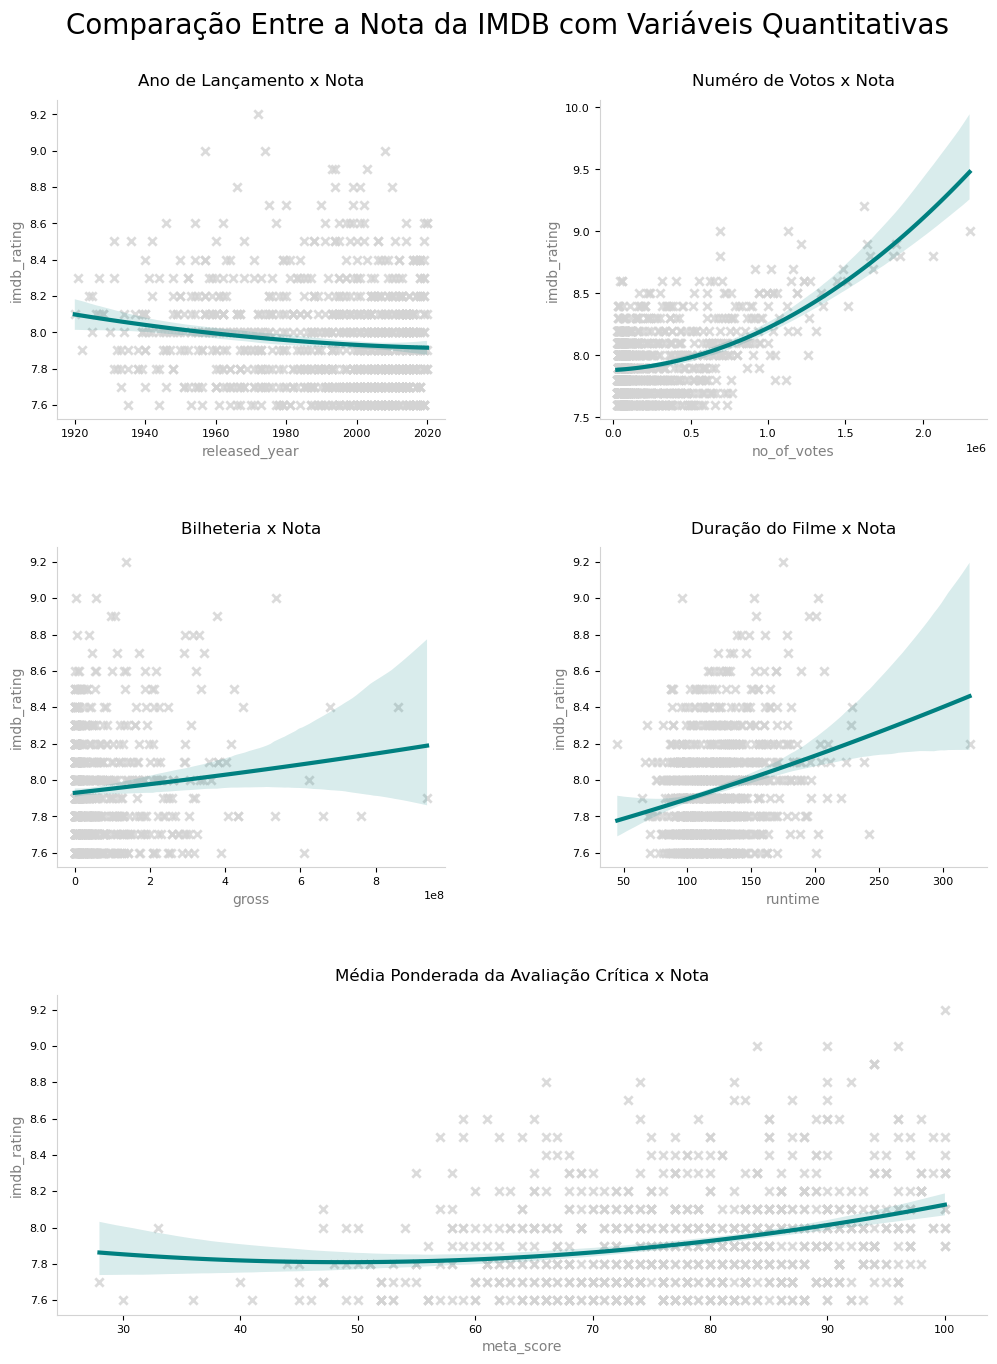

In [25]:
graficos.quan_correlation(df)

**Analisando o gráfico de Comparação acima**

* *Sobre o modelo utilizado*
  * O gráfico utilizado é o de dispersão entre duas variávies quantitativas junto a uma regressão. Esse tipo de modelo é bem interessante para averiguar|confirmar se há uma correlação entre as variávies e para qual direção ela aponta.  Diferente do gráfico de correlação de spearman, onde temos um valor numérico da força dessa correlação, aqui conseguimos visualizar o real comportamento dessa correlação e confirmar também o que foi dito pelo modelo anterior.
* *Ano de lançamento x Nota*
  * No gráfico de correlação, obtivemos um resultado de uma interação fraca e inversamente proporcional, isso é então observado também nesse gráfico de dispersão, com a linha de regressão apontando para baixo, indicando que ao passar do tempo a note do imdb começou a decair, mas de uma maneira bem suave, demonstrando que a correlação entre as variávies existe, porém é fraca.
* *Número de voto x Nota.*
  * Na matriz de correlação, essa comparação entre ambas as variáveis se mostrou a mais forte e no gráfico de dispersão se mostrou real, através da linha de regressão. Percebemos que a nota cresceu junto a quantidade de votos relacionada, provavelmente ligado a popularidade do filme, apelando para uma massiva participação na votação.
* *Faturamento x Nota*
  * Novamente uma ligação que se mostrou fraca (abaixo de 0.2), mas ainda existente, demonstrando que o faturamento maior tem uma leve influência sobre a nota do imdb. No gráfico, pode aparentar que a ligação é forte, mas vale ressaltar a margem de erro que aumenta de forma drastica em relação a maior for o faturamento.
* *Duração do Filme x Nota*
  * Provavelmente a ligação mais curiosa, Filmes com uma maior duração tendem a ter uma nota mais elevada. A hipótse que pode-se levantar é que em um maior tempo, há mais espaço para uma produção e desenvolvimento de uma história que agrade mais os críticos.
* *Meta_Score X Nota IMDB*
  * Aqui vemos que quanto maior a nota do meta_Score, a nota do IMDB tende também a ser maior, mas em uma correlação suave.

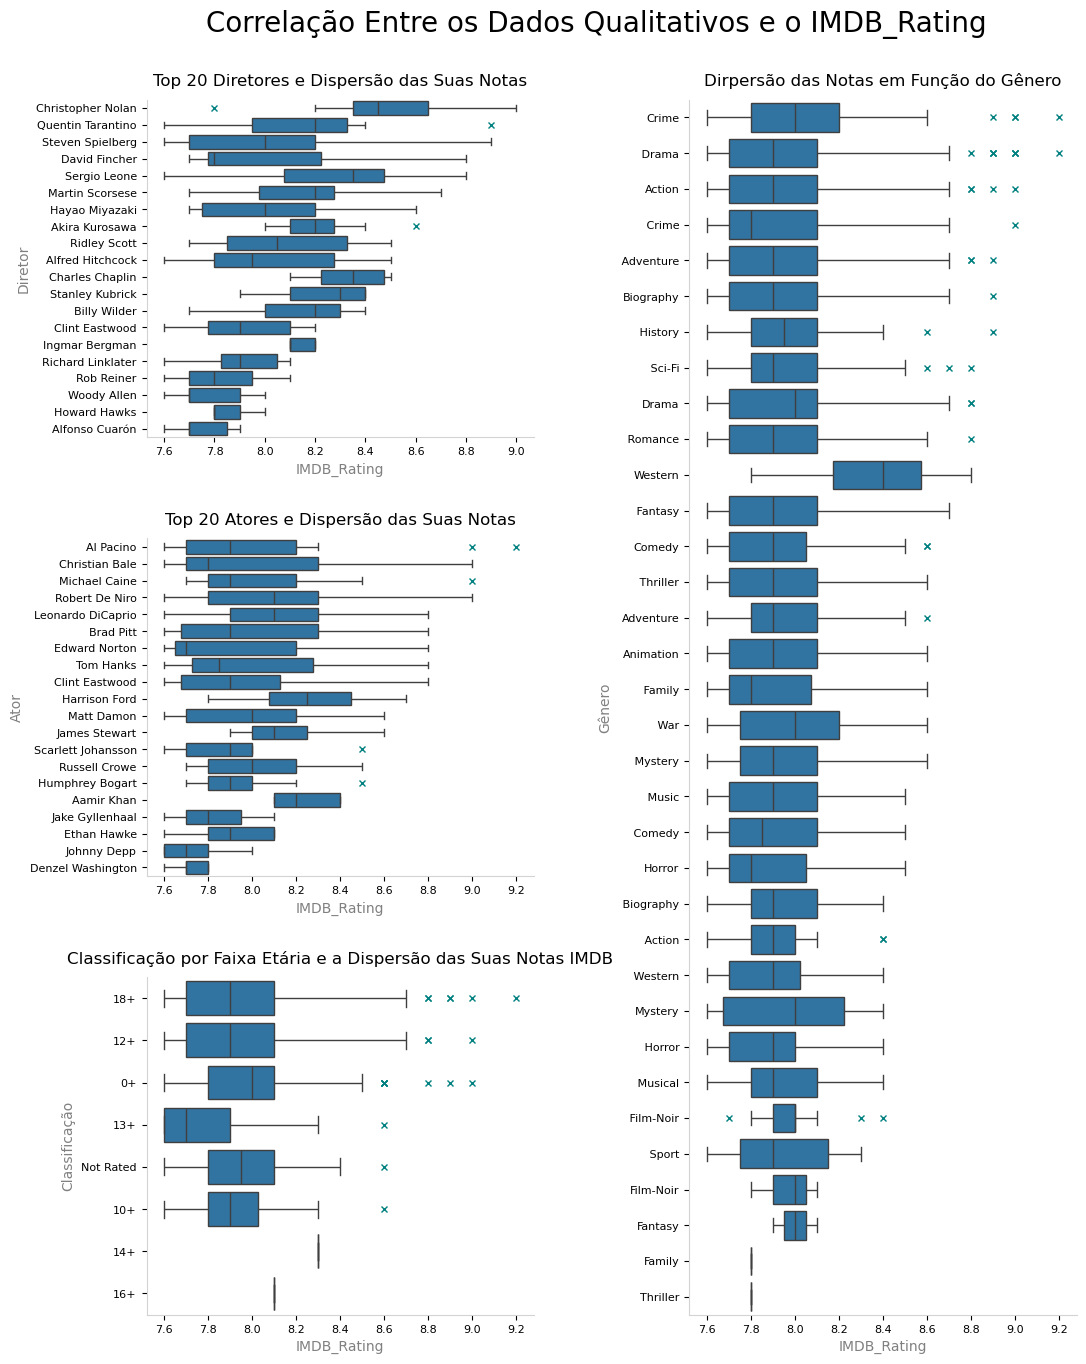

In [26]:
grafico = EDA_Target()
grafico.qual_correlation(df)

**Análise Variáveis Qualitativas com Notas IMDB**
* Análisando as notas que os diretores recebem, vemos que a quantidade de filmes tende a influênciar no range maior das notas desses diretores, ou seja, a previsão da sua nota pode ficar um pouco mais complexa, visto que ele pode receber uma nota baixa como uma alta.
* Ao avaliar os Atores, vemos que a quantidade de filme acaba influênciando também para eles superarem aquele desempenho de 8.1 apresentado anteriormente. Aqui não vemos uma ligação tão direta como em diretores, mas há sim um maior range de notas com o aumento da quantidade de filmes.
* Vemos que a faixa etária pouco influência nas notas, já que suas medianas se mantém bem próximas.
* E analisando o gênero, vemos que surpreendentemente filmes de velho oeste tendem a ter um desempenho melhor no IMDB. Fora isso, pouca alteração foi observada entre os gêneros. 

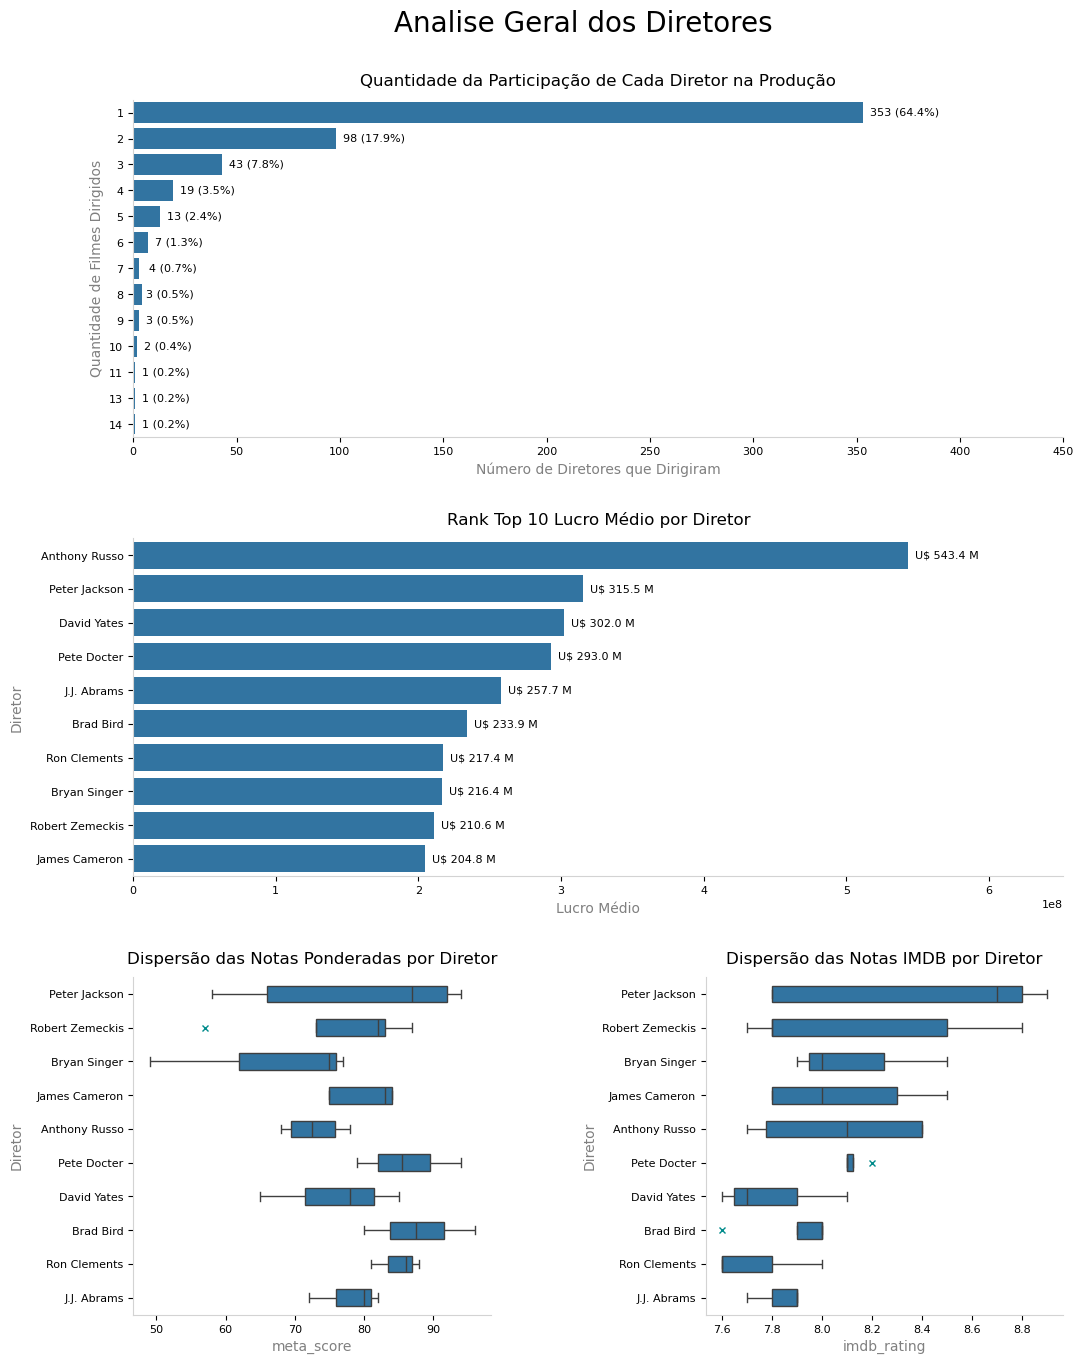

In [27]:
eda = EDA_Director()
eda.analise_diretor(df)

* **Análise dos Diretores**
  * Como vimos anteriormente, temos mais de 500 diferentes diretores que participam desse rank e no primeiro gráfico de barras acima é possível observar que mais de 64,4% só aparecem uma única vez, podendo-se concluir que uma ligação entre o nome de um diretor e a nota final seja algo bem dificil de ocorrer, mas como mais de 10% participaram de pelo menos 3 filmes, podemos ter dados proveitosos a serem utilizados aqui.
  * Ao classificar os 10 diretores com base no sucesso de bilheteria, um nome ganha destaque: Anthony Russo. Ao avaliar como as métricas de avaliação (rating e score) classificaram seus filmes, vemos uma margem curta para o score, sendo abaixo de 80. Já para o rating vemos uma margem maior,chegando a 8.5.
  * Pulando para o segundo nome, vemos Peter Jackson, que vem em segundo no lucro, porém suas notas abragem uma área maior, tendo sua concentração mais próxima aos extremos da nossa escala (demostrado pela mediana marcada nas caixas).
  * Com isso temos dois bons nomes para estudar e averiguar se seus filmes são boas recomendações. 

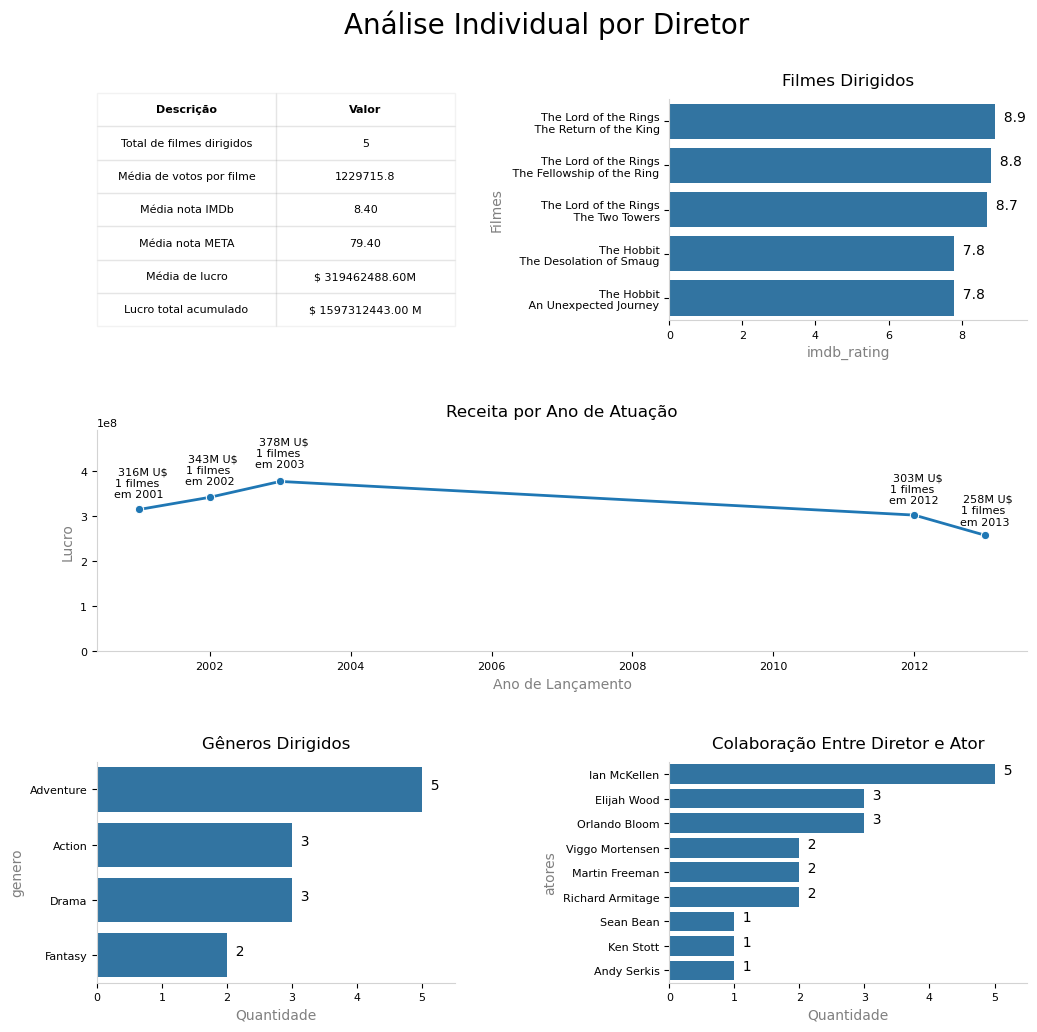

In [28]:
eda.analise_diretor_individual(df,"Peter Jackson")  

**Analisando o histórico do Diretor acima**
* Não é por menos que ele está em segundo lugar no rank, diretor de uma das maiores trilogias da história sobre aventura, fantasia e ação. Apesar de apresentar somente 5 filmes no rank, todos foram sucessos de bilheteria e com grandes premiações, então é bem provável que uma recomendação de um dos filmes desse diretor seja uma boa pedida.

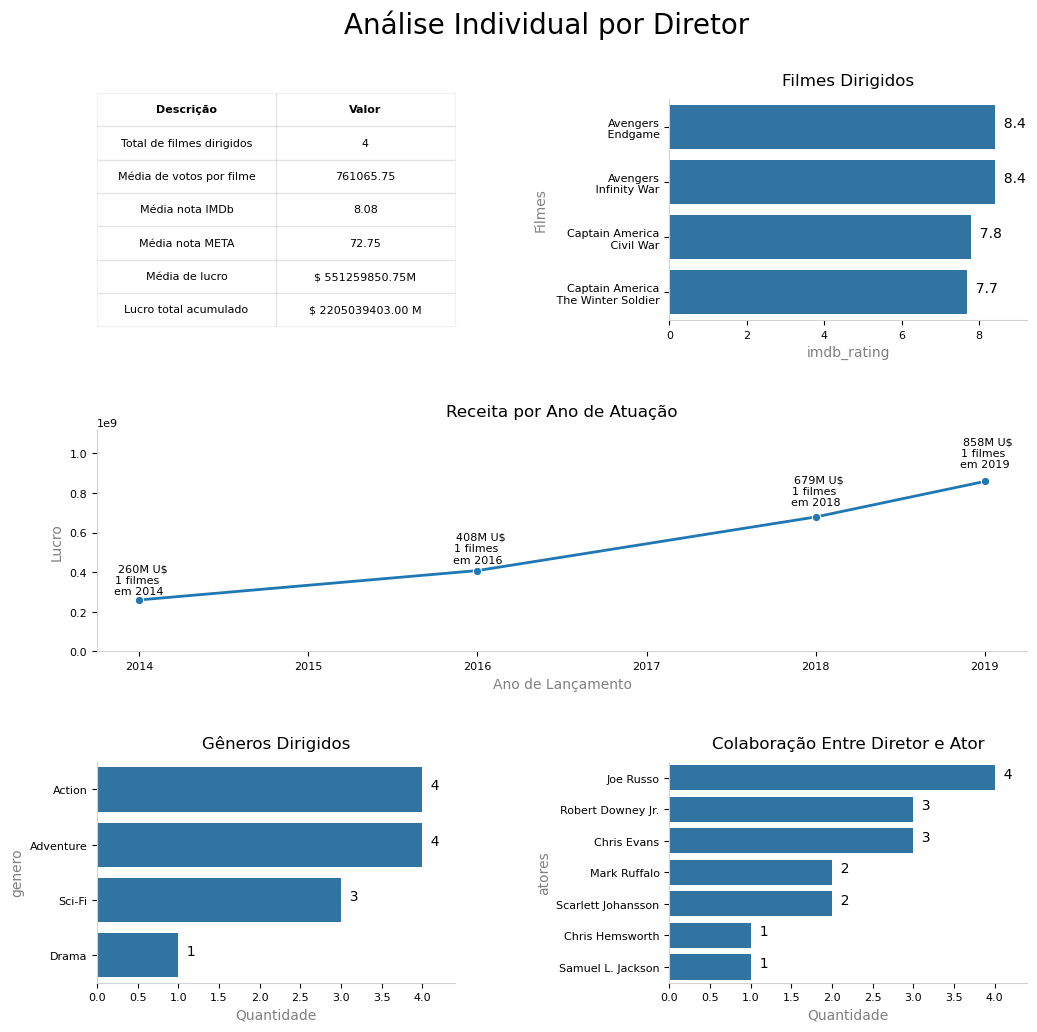

In [29]:
eda.analise_diretor_individual(df, "Anthony Russo")     

**Analisando o histórico do Diretor acima**
* Acima temos o diretor do segundo filme de maior sucesso do mundo, vingadores ENDGAME, filme de aventura e ação de sucesso mundial. Sem duvida outro filme desse seguemente do mesmo diretor é uma boa sugestão e pode ser um indicador de material de qualidade. 

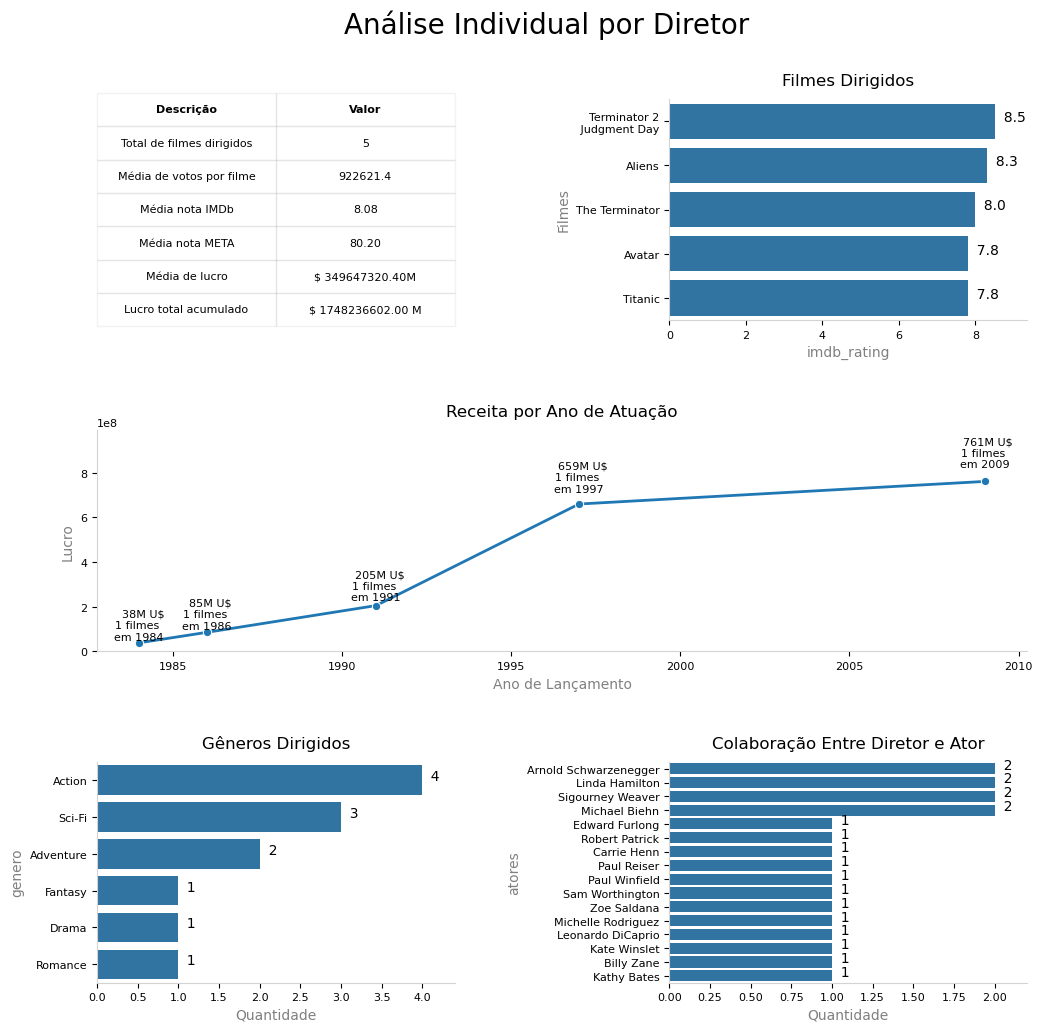

In [30]:
eda.analise_diretor_individual(df,"James Cameron")  

**Analisando o histórico do Diretor acima**
* Como menção honrosa, acima temos o James Cameron, como é possível avaliar acima ele é o diretor de diversos filmes classicos, incluindo o de maior bilheteria da história, Avatar.
* A análise acima acaba de confirmar uma suspeita, o resultado de lucro mostrado acima é a bilheteria feita nos EUA e não a mundial, tanto que ENDGAME é a segunda mundial, mas sua bilheteria nos EUA foi maior que Avatar, que detêm o record mundial. 

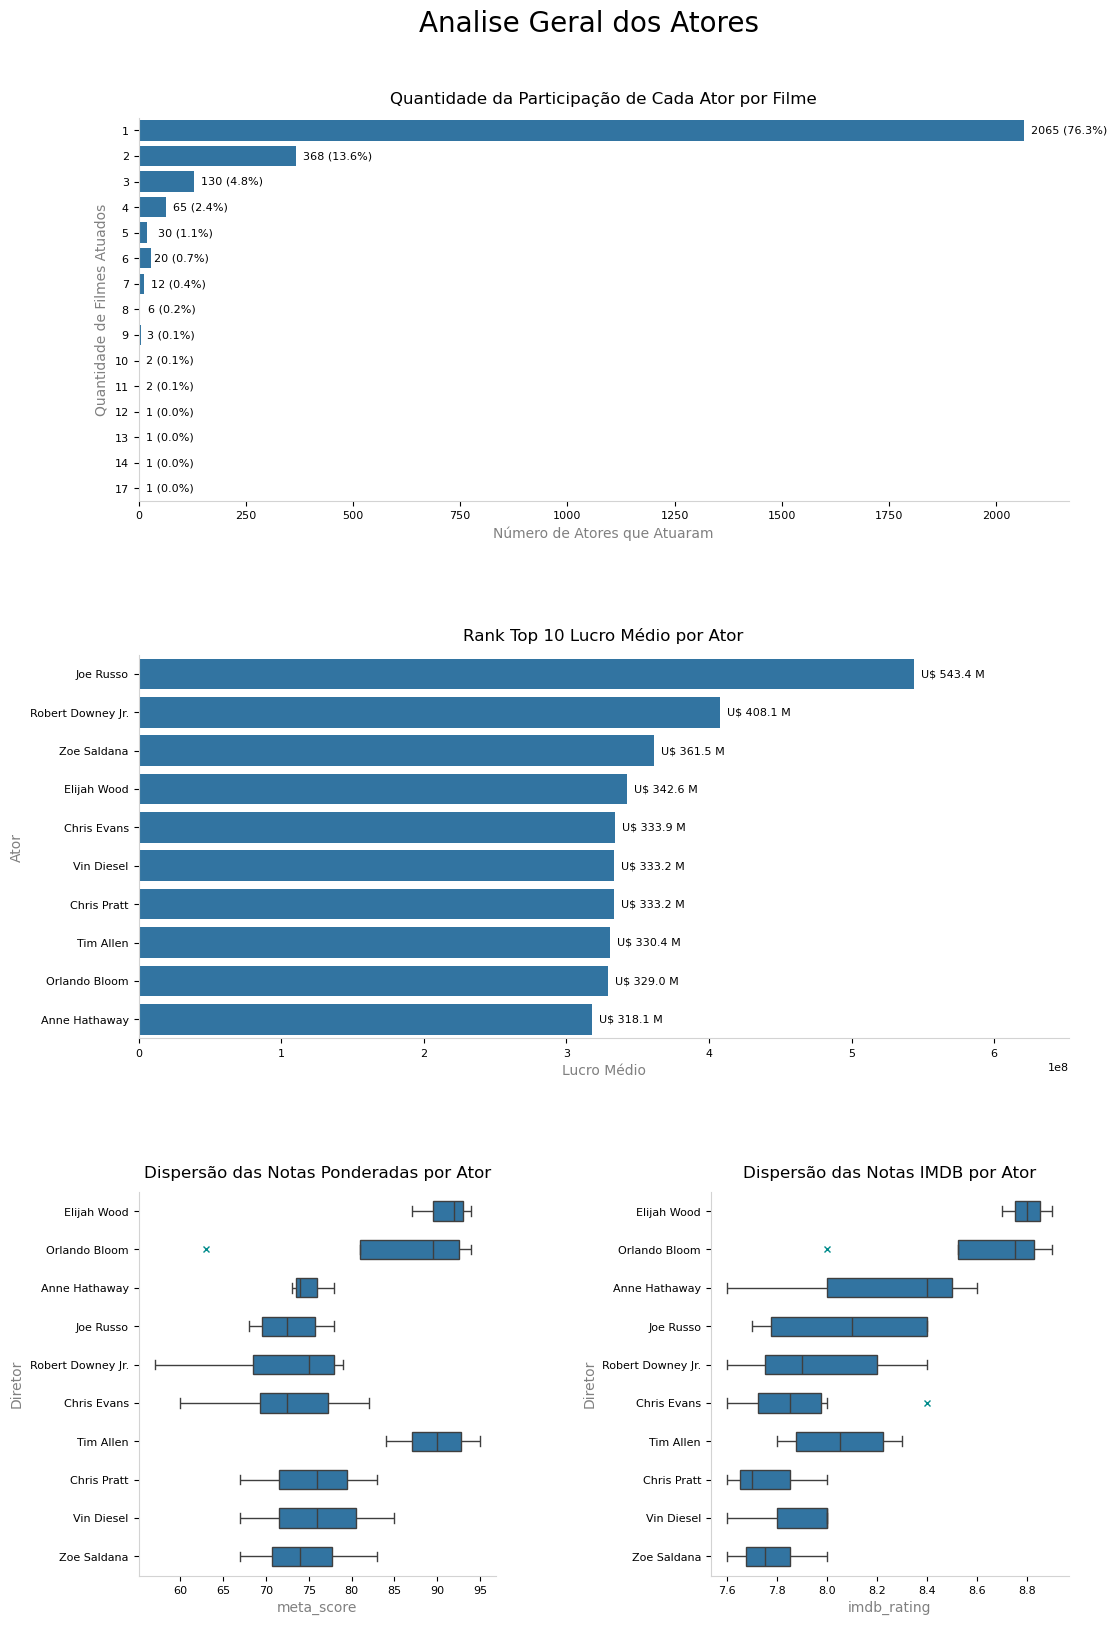

In [31]:
eda = EDA_Actor()
eda.analise_ator(df)   

**Analisando os Atores Acima**
* A grande maioria dos atores atuaram somente uma ou duas vezes nos filmes, não chegando nem a 10% a quantidade de atores que atuaram 3 ou mais vezes.
* É possível observar um erro nos dados, com o Joe Russo classificado como uma estrela. Ele atua junto ao seu irmão Anthony Russo na direção dos filmes, então vemos que ele foi colocado como estrela, mas seu lugar era como diretor ao lado do irmão.
* Como destaque temos Robert Downey Jr, sendo um dos que mais trabalharam com o anthony russo. Demonstrando que a parceria deles 2 tende a ser um sucesso comercial, mas sua avaliação ficou baixo.
* Em destaque para a avaliação temos Elijah Wood, que conseguiu uma surpreendente variação micro nas notas mais altas, tanto para o imdb quanto para o meta.

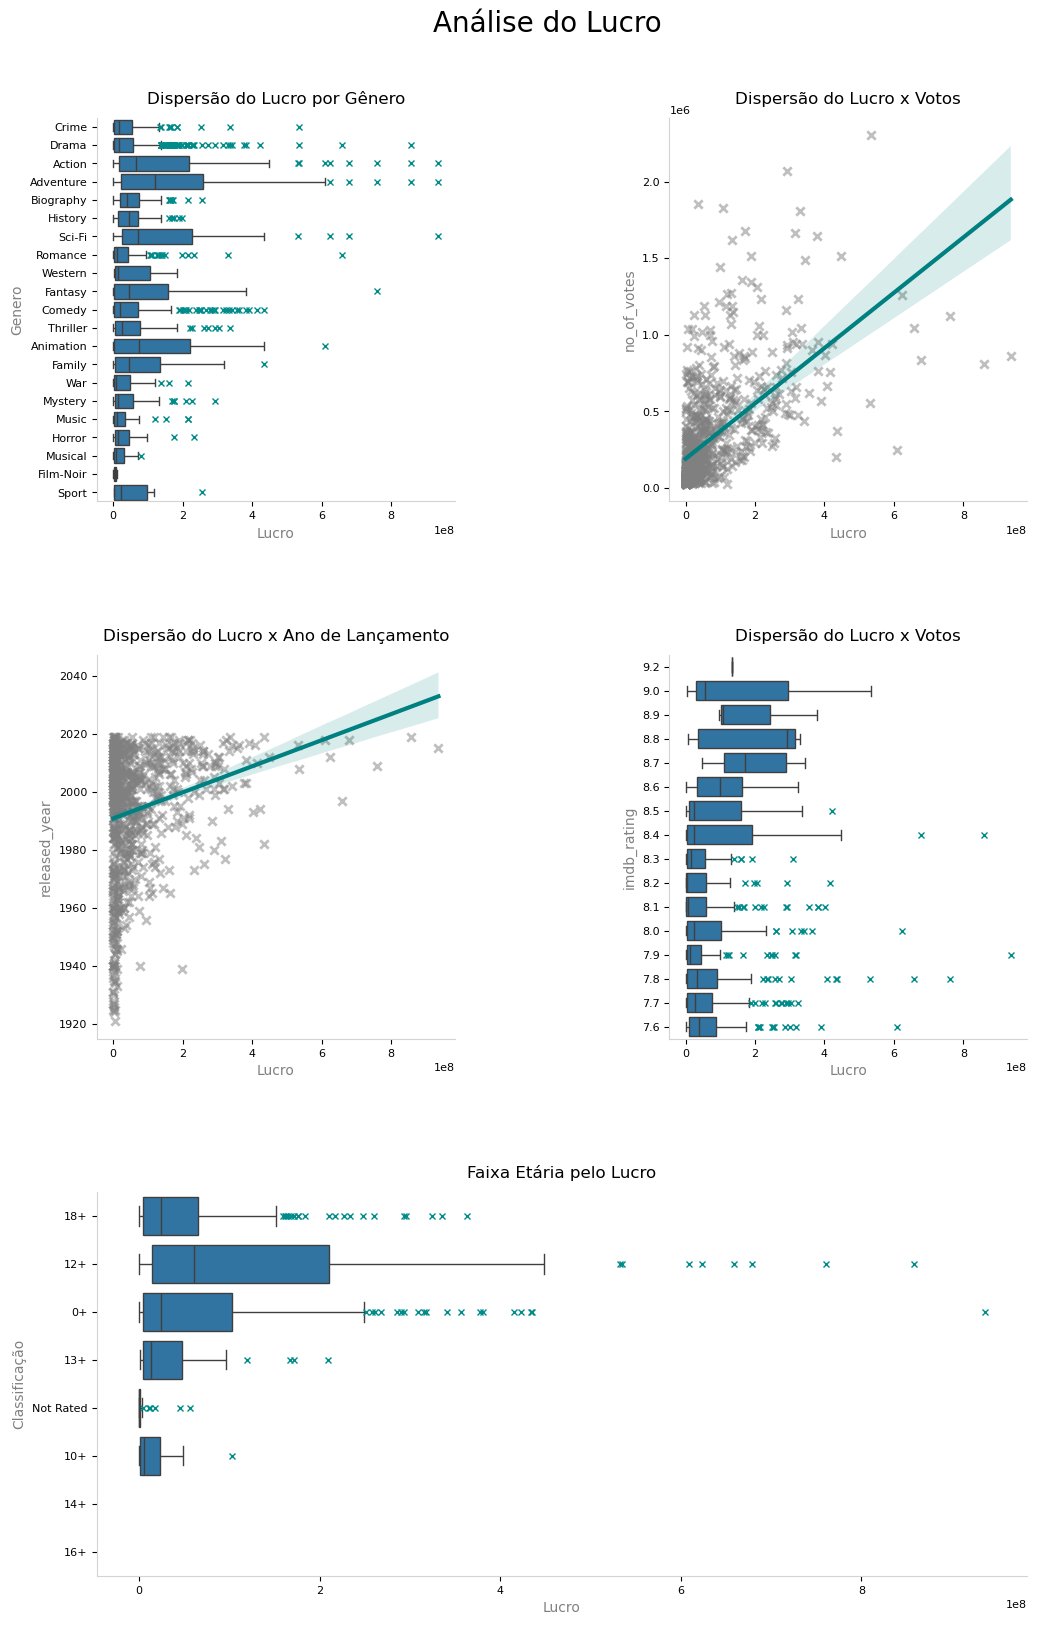

In [32]:
grafico = EDA_Lucro()
grafico.analise_lucro(df)

**Análise do Lucro**
* *Lucro por Gênero*
  * 5 são os gêneros que se destacam ao avaliar o faturamento: Family, Fantasy, Action, Animation e Adventure. Como foi observado anteriormente analisando os diretores de maior sucesso, a maioria dos filmes estão relacionados com esses gêneros acima citadas, sendo eles bem agradável desde o público infantíl até o público adulto. Então visando o lucro, a escolha de um dos temas acima é um ótimo indicador de sucesso.
* *Lucro por Votos*
  * Aqui vemos uma correlação já forte entre os dois, quanto maior o número de votos, maior é o lucro. Provavelmente a popularidade do filme que trás o engajamento das pessoas a participarem da votação é só um reflexo do sucesso do faturamento.
* *Tempo de Duração x Lucro*
  * A correlação aqui pode ser explicada por dois fatores, sendo um deles a provável inflação que ocorreu ao longo do tempo. Fazendo que o ingresso seja mais caro e consequentemente o valor total vá ser maior no final. Outro fator envolvido pode ser a popularização maior do cinema, mas isso cai mais como uma segunda opção.
* *IMDB nota x Lucro*
  * Apesar das notas do IMDB serem valores flutuantes, devido a só os melhores filmes estarem nessa lista, só existe 16 variações desse valor. Então podemos aproveitar a baixa quantidade de classes para fazer uma avaliação da dispersão do lucro dos filmes por nota do IMDB. A avaliação da caixa pode ser feita de 2 maneiras, primeiro vamos ver o TODO. Olhando de baixo para cima vemos que os box tendem a crescer de tamanho, isso demonstra que quanto maior a nota, um maior lucro passa a fazer parte da distribuição daquela nota e não somente um outlier. A outra maneira de avaliar é cada caixa individualmente, dando destaque para filmes com nota 9 pelo grande range de faturamento e vemos que a partir de 8.4 o range de lucro tende a ser maior, então o lucro é um bom indicativo de qual nota o filme pode receber.
* *Faixa etária x Lucro*
  * Vemos que os filmes de 12 + foram o que obtiveram um maior range de lucro, superando o dos adultos e dos filmes livres.

#  Questionamentos Levantados 
**Recomendação de Filme**
* Como observado na análise exploratória dos dados, minha escolhe será com base na popularidade do filme, mas para um filme realmente ser bom ele precisa de uma excelente direção. Sendo assim, usei como base de escolha da recomendação o diretor. Para isso 4 são os pontos avaliados: Popularidade (será usada mediana da bilheteria desse diretor, visto que filmes populares têm alta bilheteria), Nota média da IMDB (como avaliamos anteriomente, se um filme apresentar uma média maior de 8.1 já é um excelente resultado), o desempenho ao longo dos anos de bilheteria para averiguar se ele se manteve relevante e que seja um filme que tenha aventura e ação, pois ambos foram o que apresentaram um maior range de faturamento no gênero. Então ao analisar desempenho nesses aspectos, vemos que o diretor `Peter Jackson` se encaixa bem, sendo assim o filme "Senhor dos aneis: A sociedade do anel" é a escolha como recomendação de filme.

  
**Faturamento do Filme**
* Como foi comentado anteriormente na Análise Exploratória, tanto no gráfico de correlação como na análise individual do faturamento, podemos destacar 2 correlações: O ano de lançamento do filme e o número de votos sendo os dois principais. 4 outros fatores apresentam uma correlação mais fraca: o tempo de duração, nota imdb, gênero e faixa etária.


**Classificação do Gênero Pelo Texto**
* Para saber o nível de importância do overview para inferir o gênero do filme foi criado uma rede neural LSTM. Os resultados obtídos alcançaram um acurácia de 31%, se mostrando não tão eficiênte. Para saber mais sobre todo o processo, confira abaixo a Análise de Texto.

## Análise de Texto

**Função Para tratamento de Texto**
* Essa função realiza o pré-processamento de texto para tornar os dados mais adequados para análise por modelos de aprendizado de máquina ou outras tarefas de Processamento de Linguagem Natural (NLP). Primeiro, converte o texto para minúsculas para padronização. Em seguida, remove pontuações e números para focar apenas no conteúdo textual relevante. Depois, divide o texto em palavras individuais e remove palavras comuns e não informativas, conhecidas como stopwords. Em seguida, aplica lematização para reduzir palavras à sua forma base e, opcionalmente, stemming para reduzir palavras à sua raiz. Finalmente, junta as palavras processadas de volta em um único texto. Essas etapas ajudam a melhorar a qualidade e a consistência dos dados de texto para análise posterior.

In [33]:
def preprocess_text(text):
    # Converte para minúsculas
    text = text.lower()
    
    # Remove pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove números
    text = re.sub(r'\d+', '', text)
    
    # Tokenização
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatização
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Junta as palavras de volta em um único string
    text = ' '.join(words)

    return text

In [34]:
# Criando o Dataset Para análise
pln = df.loc[:,["overview","genre"]]
pln.head()

,overview,genre
0,An organized crime dynasty's aging patriarch t...,"Crime, Drama"
1,When the menace known as the Joker wreaks havo...,"Action, Crime, Drama"
2,The early life and career of Vito Corleone in ...,"Crime, Drama"
3,A jury holdout attempts to prevent a miscarria...,"Crime, Drama"
4,Gandalf and Aragorn lead the World of Men agai...,"Action, Adventure, Drama"


In [35]:
# Aplicar a função para tratamento do texto. 
pln["overview"] = pln["overview"].apply(preprocess_text)
pln["overview"][0]

'organ crime dynasti age patriarch transfer control clandestin empir reluct son'

**Modelo de Previsão**
* O problema aqui presente é chamado de multilabel, na classificação multilabel dos gêneros de filmes, cada filme pode ser associado a múltiplos rótulos de gênero simultaneamente. Isso significa que um filme pode ser categorizado em mais de uma categoria de gênero, como ação, drama, e comédia ao mesmo tempo. O modelo de aprendizado de máquina será treinado para prever esses múltiplos rótulos de gênero para cada filme com base em seu resumo ou outras características textuais fornecidas.

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

* Esse trecho de código realiza a preparação de texto para modelos de aprendizado de máquina usando o TensorFlow. Primeiramente, define-se o tamanho máximo do vocabulário e o comprimento máximo das sequências de texto. O Tokenizer do TensorFlow é então inicializado para converter os textos em sequências de números (tokens), limitando o vocabulário ao número especificado e usando um token especial para palavras fora do vocabulário. Após ajustar o Tokenizer aos textos, cada texto é transformado em uma sequência numérica. Em seguida, as sequências são ajustadas para terem o mesmo comprimento, preenchendo as mais curtas e truncando as mais longas, criando dados prontos para serem usados em modelos de machine learning.


In [37]:
# Tokenização e vetorização usando Tokenizer do TensorFlow
vocab_size = 1000
max_len = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(pln['overview'])
sequences = tokenizer.texts_to_sequences(df['overview'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

* Criar um Dummies para a classificação Multilabel

In [38]:
generos = pln['genre'].str.get_dummies(sep=', ')
generos.head(1)

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Separação dos dados para treinamento

In [39]:
# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, generos, test_size=0.2, random_state=42)

*  LSTM (Long Short-Term Memory) é um tipo especial de rede neural projetado para lidar com sequências de dados, como texto, áudio ou séries temporais. Ele resolve o problema de "desaparecimento do gradiente" das redes neurais recorrentes tradicionais, permitindo que modelos aprendam dependências de longo prazo em dados sequenciais. O funcionamento do LSTM é baseado em unidades chamadas células LSTM, que têm a capacidade de manter informações por longos períodos (memória de longo prazo) e curtos períodos (memória de curto prazo). Isso é alcançado através de mecanismos como portas de esquecimento (para decidir o que lembrar ou esquecer), portas de entrada (para decidir o que adicionar à memória) e portas de saída (para decidir o que será a saída) 
Para a classificação multilabel de texto, como no caso de prever múltiplos gêneros de filmes com base em seus resumos, o LSTM é escolhido porque ele pode capturar relações complexas e contextos semânticos longos entre palavras e frases nos textos. Ele é eficaz em manter informações relevantes ao longo de sequências longas de dados, permitindo uma compreensão profunda e uma melhor previsão de múltiplas etiquetas (gêneros) associadas a cada filme.

* Para aplicação do modelo foi utilizado o Tensorflow, sendo um dos modelos mais utilizados de rede neural no mundo.

In [40]:
# Construindo o modelo LSTM
embedding_dim = 32

model = Sequential([
    Embedding(vocab_size, embedding_dim),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=3)])

# Avaliando o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Acurácia do modelo: {accuracy * 100:.2f}%')

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.0126 - loss: 7.7943 - val_accuracy: 0.0000e+00 - val_loss: 7.5627
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.0036 - loss: 7.7998 - val_accuracy: 0.0000e+00 - val_loss: 7.5094
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0440 - loss: 8.0347 - val_accuracy: 0.3100 - val_loss: 7.3125
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2216 - loss: 8.0089 - val_accuracy: 0.3100 - val_loss: 7.2177
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2241 - loss: 8.1750 - val_accuracy: 0.3100 - val_loss: 7.3446
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2322 - loss: 8.6194 - val_accuracy: 0.3100 - val_loss: 7.6041
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2483 - loss: 9.0468 - val_accuracy: 0.3100 - val_loss: 7.9162
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3110 - loss: 7.9857
Acurácia do modelo: 31.00%


# Modelo De Previsão
* **Problemática e Preparação dos Dados**
  * O problema proposto aqui é para a criação de um modelo de machine learning que seja capaz de realizar a previsão das notas do IMDB de forma eficiente. Começando a falar sobre os dados utilizados, as colunas de nome do filme e sua descrição foram removidas, visto que ambos não tem muito a acrescentar nas notas do IMDB. A primeira transformação necessária é a criação de dummies, dummies são colunas criadas a partir de uma única coluna que há diversas classes, aqui o desafio é que tanto os atores como os gêneros podem ter mais de 1 presente no mesmo filme, sendo então necessário todo um tratamento para poder fazer a criação de colunas de cada gênero e de cada nome de ator. O conteúdo dessas coluna são valores 0 ou 1, sendo 1 marcado como verdadeiro e 0 como falso. Além dessas, todas as outras variáveis qualitativas foram transformadas em dummies. Outro tratamento necessário foi o uso do encoder, básicamente transforma dados qualitativos em numéricos permitindo então que o modelo de ML compreenda os dados. Na análise exploratória dos dados foi possível observar os tipos de distribuição dos dados numéricos, sendo nenhum deles uma distribuição normal, sendo esse tipo de distribuição mais adequado para os modelos funcionarem melhor. Uma possível solução para se aproximar ao máximo da distribuição normal é fazendo o PowerTrasnformation, que no caso foi usado a transformação de log para melhorar a distribuição dos dados numéricos. Foi aplicada então a normalização dos dados, normalizar os dados para um intervalo específico (geralmente entre 0 e 1), garantindo que todas as características tenham a mesma ordem de grandeza. Isso ajuda a evitar que características com valores maiores dominem aquelas com valores menores durante o treinamento.
 
---
* **Modelos de Machine Learning**
* *Rede Neural*
  * Com o tratamento descrito acima o resultado é um dataset com uma grande quantidade de entradas e há um modelo que se destaca com dados com muitas features que são as redes neurais, elas podem lidar eficientemente com alta dimensionalidade, aprendendo representações hierárquicas das características e incorporando regularização para evitar overfitting. Isso as torna adequadas para problemas onde há uma grande quantidade de variáveis de entrada, permitindo explorar e extrair informações significativas dos dados de forma eficaz. No entanto, redes neurais exigem grandes quantidades de dados e poder computacional para treinamento, são propensas a overfitting em pequenos conjuntos de dados e podem ser difíceis de interpretar devido à sua complexidade. A biblioteca escolhida para a criação do modelo foi o PyTorch, uma biblioteca de aprendizado de máquina de código aberto desenvolvida pelo Facebook. PyTorch é amplamente utilizada tanto na pesquisa quanto na indústria devido à sua flexibilidade e facilidade de uso.

* *XGBoost*
  * A escolha da biblioteca XGBoost para a construção e treinamento do modelo reflete sua popularidade na comunidade de ciência de dados e machine learning. Em comparação com redes neurais, que podem demandar grandes volumes de dados e poder computacional substancial, o XGBoost é frequentemente preferido por sua eficiência computacional e simplicidade de implementação, oferecendo resultados robustos e interpretáveis em uma variedade de aplicações práticas. O XGBoost é particularmente eficaz em cenários que envolvem um grande número de variáveis de entrada (features), graças ao seu processo de treinamento sequencial de árvores fracas de decisão e à flexibilidade na configuração de hiperparâmetros como max_depth, learning_rate, colsample_bytree, entre outros. Essa abordagem ajuda a mitigar o overfitting e melhora a capacidade de generalização do modelo, mesmo em dados complexos e variados.
---
* **Métricas de Avaliação**
  * Como estamos diantes de um problema de regressão, a métrica para avaliação vai ser a comparação do valor previsto para o real, específicamente irei usar o método chamado de RMSE (Root mean square error ou Raíz do erro médio quadrático), ele calcula a raiz quadrada da média dos quadrados dos erros, onde os erros são as diferenças entre os valores previstos pelo modelo e os valores reais observados. O RMSE é uma medida da dispersão dos resíduos, indicando o quão bem o modelo se ajusta aos dados observados. É um modelo fácil de interpretar, pois tem a mesma unidade que a variável de saída e ele penaliza erros grandes mais do que erros pequenos devido à elevação ao quadrado dos resíduos, o que é útil quando grandes erros são indesejáveis

---
* **Conclusão dos Modelos Usados**
  * Rede Neural -> Com o modelo usado a métrica de RMSE alcançada foi de 0.35, ou seja, cada previsão vai fazer uma variação que pode ir até 0.35 pra cima ou para baixo. Ao analisar o gráfico vemos que o resultado não foi tão bom, principalmente quando temos filmes com notas mais elevadas. Apesar de funcionar bem com altas dimensões, a maioria das características de entrada são completamente inúteis (sendo nome de atores e diretores), praticamente uma matriz esparsa.
  * XGBoost -> Com o modelo baseado em árvore de dimensão o resultado apresentado foi bem melhor, com a métrica de RMSE alcançando 0.18, para mais e para menos e nos gráficos vemos uma generalização muito superior ao modelo de rede neural, sendo assim o modelo criado será do XGBoost.







In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

**Função para transformação dos dados**

In [174]:
class TratamentoML:
    def __init__(self):
        self.dummies_columns = None
        self.scaler = None

    def data_transformation(self, data, teste=False):
        """
        Realiza o tratamento dos dados de treinamento.

        Args:
            data (pd.DataFrame): Dados de entrada para treinamento.

        Returns:
            pd.DataFrame: Dados tratados e escalados.
            pd.Series: Valores alvo (imdb_rating).
        """
        # Criar cópia e excluir colunas desnecessárias
        X = data.copy()
        excluir = ["series_title", "overview"]
        X = X.drop(excluir, axis=1)
        y = X.pop('imdb_rating')
        # Limpar dados com vázios.
        X = X.dropna()
        
        # Realizar o join entre X e y com base nos índices
        X = X.join(y, how='inner')
        y = X.pop('imdb_rating')

        if teste==True:
            id = X.pop("id").tolist()
            
            
        # Processar colunas categóricas
        X_ = X.copy()
        X_['index'] = X_.index  # Preservar o índice original
        X_ = X_.assign(genero=X_["genre"].str.split(',')).explode('genero')
        X_ = X_.assign(atores=X_["stars"].str.split(',')).explode('atores')
        X_ = X_.drop(["genre", "stars"], axis=1)  # Remover Gênero e Atores
        X_ = pd.get_dummies(X_, columns=["genero", "atores", "director", "certificate"])

        # Salvar colunas dummies
        self.dummies_columns = X_.columns.tolist()

        # Agrupar de volta combinando as colunas dummy
        X_ = X_.groupby('index').max()
        X_.index.name = None  # Remover o nome do índice

        # Transformar em Numéricos
        for col in X_.select_dtypes(exclude=np.number):
            X_[col] = LabelEncoder().fit_transform(X_[col])

        # Aplicar power transformation para normalizar a distribuição
        for col in ["no_of_votes", "gross", "released_year", "runtime", "meta_score"]:
            X_[col] = np.log(X_[col])

        
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)

        if teste == True:
            X_scaled["id"] = id
            return X_scaled, y

        return X_scaled, y

    def transformar_dados_teste(self, dados_treino, dados_teste):
        """
        Transforma os dados de teste usando os parâmetros dos dados de treinamento.

        Args:
            dados_treino (pd.DataFrame): Dados de treinamento.
            dados_teste (pd.DataFrame): Dados de teste.

        Returns:
            pd.DataFrame: Dados de teste transformados.
        """
        # Concatenar dados de treino e teste
        #dados_teste['IMDB_Rating'] = np.nan  # Adicionar coluna alvo nos dados de teste
        dados_combinados = pd.concat([dados_treino, dados_teste], ignore_index=True, axis=0)

        
        # Realizar o tratamento de dados em todo o conjunto
        dt_tratado = data_treatment(dados_combinados)
        dt_tratado = dt_tratado.reset_index()
        dt_tratado = dt_tratado.rename(columns={'index': 'id'})
        ids_teste = dt_tratado.loc[dados_treino.shape[0]:, 'id'].tolist()
        ids_treino = list(set(dt_tratado["id"]) - set(ids_teste))
        
        # Realizar o tratamento de dados em todo o conjunto
        X_scaled, y = self.data_transformation(dt_tratado, True)

        # Separar os dados transformados de teste
        dados_teste_transformados = X_scaled.loc[X_scaled["id"].isin(ids_teste)]
        dados_teste_transformados = dados_teste_transformados.drop(columns='id')
        
        dados_treino_transformados = X_scaled.loc[X_scaled["id"].isin(ids_treino)]
        dados_treino_transformados = dados_treino_transformados.drop(columns='id')
        
        y = y.dropna()
        
        return dados_treino_transformados, y, dados_teste_transformados

**Dados a serem testados**

In [ ]:
teste = dados_teste = pd.DataFrame([{
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}])

**Dados Transformados**

In [175]:
X, y, X_teste = TratamentoML().transformar_dados_teste(dados, teste)

In [182]:
X.head()

,released_year,runtime,meta_score,no_of_votes,gross,genero_ Action,genero_ Adventure,genero_ Biography,genero_ Comedy,genero_ Crime,...,director_Yôjirô Takita,director_Zack Snyder,director_Zaza Urushadze,director_Zoya Akhtar,certificate_0+,certificate_10+,certificate_12+,certificate_13+,certificate_18+,certificate_Not Rated
0,0.505959,0.745794,1.000000,0.918626,0.856325,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.885412,0.629304,0.863034,0.996213,0.958445,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.527221,0.864414,0.917232,0.839093,0.792788,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.345805,0.249397,0.967932,0.730220,0.601758,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.833119,0.860312,0.951393,0.921654,0.932672,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [180]:
X_teste

,released_year,runtime,meta_score,no_of_votes,gross,genero_ Action,genero_ Adventure,genero_ Biography,genero_ Comedy,genero_ Crime,...,director_Yôjirô Takita,director_Zack Snyder,director_Zaza Urushadze,director_Zoya Akhtar,certificate_0+,certificate_10+,certificate_12+,certificate_13+,certificate_18+,certificate_Not Rated
749,0.738662,0.573043,0.824706,1.0,0.740579,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [181]:
y

0      9.2
1      9.0
2      9.0
3      9.0
4      8.9
      ... 
989    7.6
990    7.6
991    7.6
993    7.6
996    7.6
Name: imdb_rating, Length: 749, dtype: float64

**Separação dos Dados em Treino e Teste**

In [292]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pickle
import xgboost as xgb

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(561, 2500) (188, 2500) (561,) (188,)


**Função da Rede Neural com PyTorch**

In [261]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.1)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)  # Linear output for regression
        return x

In [285]:
class DeepLearning:
    def __init__(self, input_size, epoch, dados):
        self.model = Net(input_size)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        self.num_epochs = epoch
        self.dados = dados
        self.data_transform()
        
    def data_transform(self):
        train_dataset = TensorDataset(self.dados['X_train'], self.dados['y_train'])
        test_dataset = TensorDataset(self.dados['X_test'], self.dados['y_test'])
        
        batch_size = 16
        
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=batch_size)
     
    def train_model(self):
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels.view(-1, 1))
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                
            epoch_loss = running_loss / len(self.train_loader.dataset)
            if epoch % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.num_epochs}], Loss: {epoch_loss:.4f}')
        print('Training finished.')   
             
    def test_model(self):
        self.train_model()
        self.model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                outputs = self.model(inputs)
                y_true.extend(labels.tolist())
                y_pred.extend(outputs.tolist())

        return y_true, y_pred

    def evaluate_input(self, input_data):
        self.model.eval()
        input_tensor = torch.tensor(input_data.values, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            output = self.model(input_tensor)
        return output.item()
        

    def save_model(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.model.state_dict(), f)
        print(f'Model saved to {filepath}')

def rmse(y_true, y_pred):
    """
    Calcula a raiz do erro quadrático médio (RMSE).
    
    Parâmetros:
    y_true (list ou numpy array): Valores reais observados.
    y_pred (list ou numpy array): Valores previstos pelo modelo.
    
    Retorna:
    float: A RMSE.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    error = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Plotando os valores reais vs. valores previstos
    plt.figure(figsize=(12, 5))
    
    # Comparação entre valores reais e previstos
    plt.subplot(1, 2, 1)
    plt.plot(y_true, label='Valores Reais', marker='o')
    plt.plot(y_pred, label='Valores Previstos', marker='x')
    plt.xlabel('Amostras')
    plt.ylabel('Valores')
    plt.title('Comparação entre Valores Reais e Previstos')
    plt.legend()

    # Histogramas dos valores reais e previstos
    plt.subplot(1, 2, 2)
    plt.hist(y_true, bins=20, alpha=0.5, label='Valores Reais')
    plt.hist(y_pred, bins=20, alpha=0.5, label='Valores Previstos')
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title('Distribuição de Valores Reais e Previstos')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return print(f"O RMSE foi igual a :{error}")


In [286]:

# Example usage:
# input_size should match the number of features in your dataset
input_size = X_train.shape[1]
epoch = 100
dados = {
    'X_train': torch.tensor(X_train.values, dtype=torch.float32),
    'y_train': torch.tensor(y_train.values, dtype=torch.float32),
    'X_test': torch.tensor(X_test.values, dtype=torch.float32),
    'y_test': torch.tensor(y_test.values, dtype=torch.float32)
}
model = DeepLearning(input_size, epoch, dados)
model.train_model()
y_true, y_pred = model.test_model()

Epoch [1/100], Loss: 20.3298
Epoch [11/100], Loss: 0.2897
Epoch [21/100], Loss: 0.2881
Epoch [31/100], Loss: 0.1918
Epoch [41/100], Loss: 0.1753
Epoch [51/100], Loss: 0.1372
Epoch [61/100], Loss: 0.1824
Epoch [71/100], Loss: 0.1141
Epoch [81/100], Loss: 0.1220
Epoch [91/100], Loss: 0.0906
Training finished.
Epoch [1/100], Loss: 0.0825
Epoch [11/100], Loss: 0.0628
Epoch [21/100], Loss: 0.0576
Epoch [31/100], Loss: 0.0581
Epoch [41/100], Loss: 0.0384
Epoch [51/100], Loss: 0.0203
Epoch [61/100], Loss: 0.0216
Epoch [71/100], Loss: 0.0163
Epoch [81/100], Loss: 0.0070
Epoch [91/100], Loss: 0.0048
Training finished.


In [287]:
# Evaluate a specific input
prediction = model.evaluate_input(X_teste)
print(f'Prediction for external data: {prediction}')

# Save the model
model_filepath = 'trained_model.pkl'
model.save_model(model_filepath)

Prediction for external data: 7.934481620788574
Model saved to trained_model.pkl


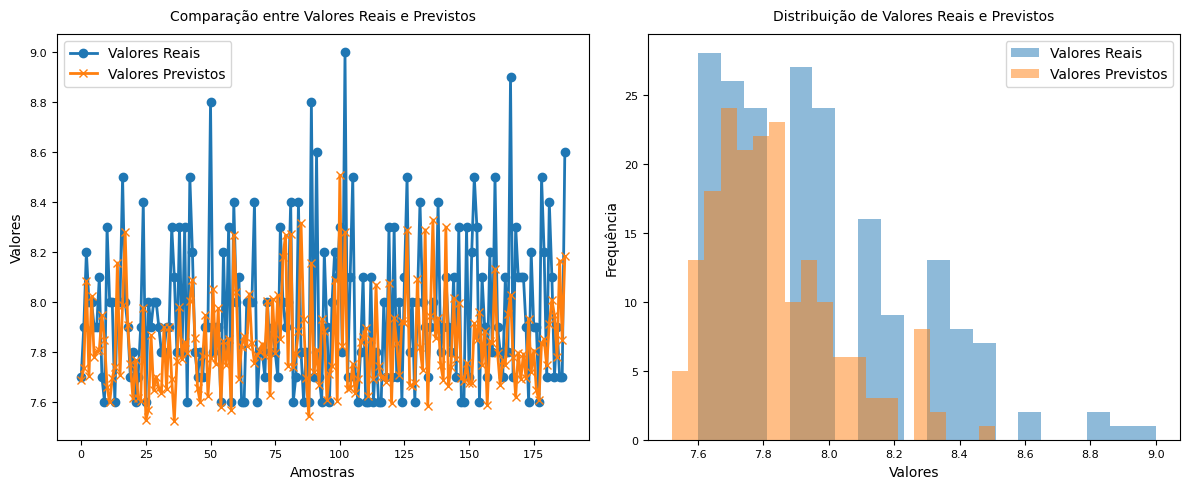

O RMSE foi igual a :0.3714263880606761


In [288]:
rmse(y_true, y_pred)

**Usando modelo baseado em Árvore de Decisão**

In [309]:
# Configurar o modelo XGBoost para regressão
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.75, learning_rate = 0.01,
                max_depth = 5, n_estimators = 2000)


In [310]:
# Treinar o modelo
xg_reg.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = xg_reg.predict(X_test)

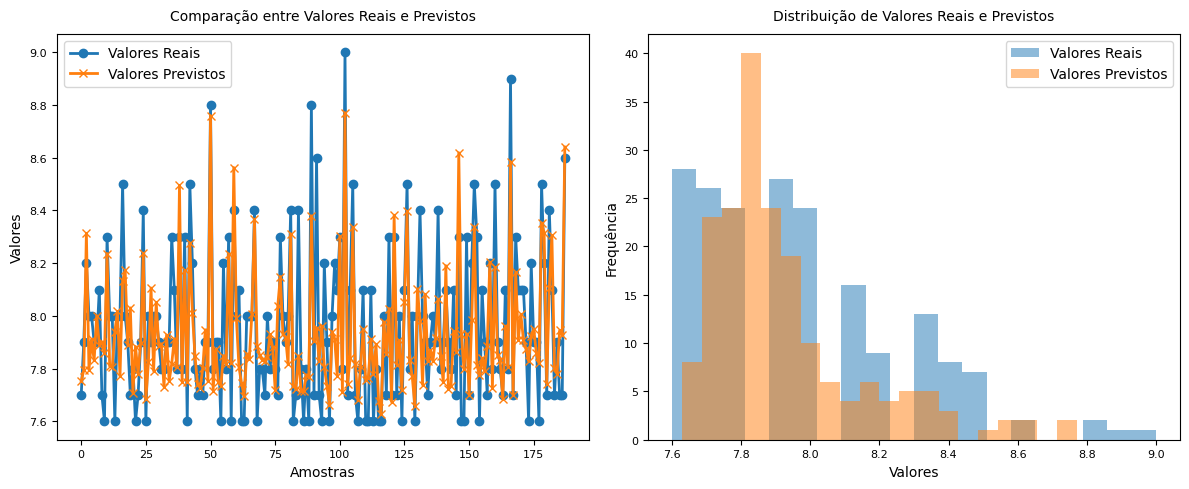

O RMSE foi igual a :0.18700872414124253


In [311]:
rmse(y_true, y_pred)

In [317]:
model_path = 'modelo_xgb.pkl'
pickle.dump(xg_reg, open(model_path, 'wb'))

In [320]:
#Nota da previsão.
xg_reg.predict(X_teste)[0]

8.783088

In [328]:
# Salvar as bibliotecas necessárias para rodar o programa.
!pip list --format=freeze > requirements.txt